#### imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os, sys, json, importlib, pickle, shutil, glob
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib as mpl
import matplotlib.patches as patches
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import scipy
import scipy.cluster.hierarchy as sch
from scipy import optimize
from scipy import stats
from scipy import integrate
import pathos.multiprocessing as mp

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import pareto
import postprocess as pp

In [3]:
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-ticks')
mpl.rcParams['savefig.dpi'] = 300

In [4]:
fig_dir = '../figures'

In [54]:
username='root'
password='password'
port = 3306
database = 'thesis'

host= 'localhost'
DATABASE_URL = 'mysql+pymysql://' + username + ":" + password + "@" + host + ":" + str(port) + '/' + database
engine = sqlalchemy.create_engine(DATABASE_URL)

#### CALVIN

In [6]:
# calvin_dir = '/Users/wyatt/Documents/repos/calvin/'
calvin_dir = '../../repos/calvin/'
if str(calvin_dir)!=sys.path:
    sys.path.append(calvin_dir)
from calvin import CALVIN, cosvfea

In [7]:
# directory for links, inflows, sr_dict, ...and result output
COSVF_DIR = os.path.join(calvin_dir,'my-models','calvin-lf')
RESULT_DIR = os.path.join(COSVF_DIR,'results')

In [8]:
# construct the calvin cosvf instance
calvin = cosvfea.COSVF(pwd=COSVF_DIR)

#### Reservoir list

In [9]:
# reservoirs
with open(os.path.join(COSVF_DIR, 'r-dict.json')) as f: 
      R_DICT = json.load(f)
rtype1_list = list({key: value for key, value in R_DICT.items() if value['type'] == 1}.keys())
rtype2_list = list({key: value for key, value in R_DICT.items() if value['type'] == 2}.keys())

In [10]:
rdf = pd.DataFrame()
rdfs = pd.DataFrame()
for r in R_DICT:
    dfr = pd.DataFrame()
    dfs = pd.DataFrame()
    if R_DICT[r]['type'] == 1:
        rdf = rdf.append(pd.DataFrame({'r':r,'lb':R_DICT[r]['lb'],'ub':R_DICT[r]['ub']},index=[0]))
        dfs['s'] = np.arange(R_DICT[r]['lb'],R_DICT[r]['ub'],1)
        dfs['r'] = r
        rdfs = rdfs.append(dfs)
        
ub, lb, kcs = {}, {}, {}
for k,v in R_DICT.items():
    ub[k] = v['ub']
    lb[k] = v['lb']
    kcs[k] = v['ub']- v['lb']

In [11]:
# pd.DataFrame(R_DICT).T.to_csv('rdict.csv')

In [12]:
sr_ns_list = ['SR_SHA','SR_CLE','SR_WHI','SR_ORO','SR_BUL','SR_RLL_CMB','SR_CLK_INV',
             'SR_BER','SR_FOL','SR_PAR','SR_CMN','SR_LVQ','SR_EBMUD',
             'SR_NHG','SR_NML','SR_SFAGG','SR_LL_ENR','SR_HTH','SR_DNP','SR_MCR','SR_SNL','SR_BUC','SR_MIL','SR_PNF','SR_ISB','SR_GNT']

#### portfolios and demand summary

In [13]:
operation_groups = pd.read_csv(os.path.join(calvin_dir,'calvin','data','operation_groups.csv'))
portfolio = pd.read_csv(os.path.join(calvin_dir,'calvin','data','portfolio.csv'))
portfolio['region_supplytype_type'] = portfolio['region'] + '_' + portfolio['supplytype'] + '_' + portfolio['type']
demands = pd.read_csv(os.path.join(calvin_dir,'calvin','data','demand_nodes.csv'))
demands['region_type'] = demands['region'] + '_' + demands['type']

## Set Result Directories

In [14]:
result_dirs = dict([('PF-Cost',os.path.join(calvin_dir,'my-models/calvin-pf/results')),
                   ('PF-OD',os.path.join(calvin_dir,'my-models/calvin-pf-no-gw-overdraft/results')),
                   ('PF-CVOD',os.path.join(calvin_dir,'my-models/calvin-pf-no-gw-overdraft-CV-only/results')),
                   ('Myopic',os.path.join(calvin_dir,'my-models/calvin-lf/results/myopic')),
                   ('NoPGW',os.path.join(calvin_dir,'my-models/calvin-lf/results/no-gw-penalty')),
                   ('CSII',os.path.join(calvin_dir,'my-models/calvin-lf-fs/results/fronts')),
                   ('Front',os.path.join(calvin_dir,'my-models/calvin-lf/results/fronts')),
                   ('Front-Ref',os.path.join(calvin_dir,'my-models/calvin-lf/results/front-ref'))
                   ])

# Pareto Post-Process

## Pareto sort

In [15]:
def assign_unique_id(df,labels,id_label):
    df[id_label] = df[labels].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)
    return df

def get_front(df,labels,f1_label,f2_label):
    
    # summarize each gen-idx to its fitness
    front = df.groupby(labels,as_index=False).aggregate({f1_label:'mean', f2_label:'mean'})
    
    # Pareto.py sort
    front = pareto.eps_sort(tables=[list(front.itertuples(False))], objectives=[len(labels), len(labels)+1])
    
    # convert to dataframe
    front = pd.DataFrame(front, columns=labels+list([f1_label,f2_label]))
    
    return front

In [16]:
COSVF_DIR = os.path.join(calvin_dir,'my-models','calvin-lf')
RESULT_DIR = os.path.join(COSVF_DIR,'results')
# seeds = [4,26,51,2]
seeds = [40,96,38,34,27]
labels = ['gen','ind','seed','f1','f2','f3']

In [17]:
# load ea history
eahist = pd.DataFrame()
front = pd.DataFrame()

# loop through seeds to load ea history and Pareto.py sort the result on F1 and F2
for seed in seeds:
    eahist_ = pd.read_csv(os.path.join(RESULT_DIR,'cosvf-ea-history-seed{}.csv'.format(seed))) \
                .sort_values(['gen','ind']) \
                .drop_duplicates(subset=['gen','ind','r','param'], keep='last', ignore_index=True)
    eahist_['seed'] = seed
    eahist_ = assign_unique_id(eahist_,['gen','ind','seed'], 'id')
    eahist = eahist.append(eahist_[['id','r','param','value','f1','f2','f3']])
    
    front_ = get_front(eahist_,['id'],'f1','f2').sort_values('f2')
    front = front.append(front_)
    
front_ref = get_front(eahist,['id'],'f1','f2')
front_ref.sort_values('f2',inplace=True)

front_positions = front[['id']].merge(eahist,on='id')
front_ref_positions = front_ref[['id']].merge(eahist,on='id')

costs = eahist.groupby(['id'],as_index=False).aggregate({'f1':'mean', 'f2':'mean', 'f3':'mean'})

In [18]:
costs['seed'] = costs.id.str.split('-').str[2].astype(int)

In [19]:
cost_cost_ub=5410
cost_od_ub=2.25
cost_od_lb=1.55
cvod_cost_ub=5450
od_od_ub=0.13

In [20]:
# front_cost = costs.loc[((costs.f2>cost_od_lb) & 
#                         (costs.f1<cost_cost_ub) & 
#                         (costs.f2<cost_od_ub))][['id','seed','f1','f2']].copy()
front_cost = front.loc[((front.f2>cost_od_lb))][['id','f1','f2']].copy()
front_cost['type'] = 'Cost'
front_cost['ind'] = front_cost.id.str.split('-').str[1].astype(int)
front_cost['seed'] = front_cost.id.str.split('-').str[2].astype(int)
front_cost = front_cost.drop_duplicates(['seed','f1','f2'],'last')
front_cost = front_cost.drop_duplicates(['ind','seed'],'last')

# front_knee = costs.loc[((abs(0.73-costs.f2)<0.02) & (costs.f1<cvod_cost_ub))][['id','seed','f1','f2']].copy()
front_knee = front.loc[((abs(0.73-front.f2)<0.04))][['id','f1','f2']].copy()
front_knee['type'] = 'CVOD'
front_knee['ind'] = front_knee.id.str.split('-').str[1].astype(int)
front_knee['seed'] = front_knee.id.str.split('-').str[2].astype(int)
front_knee = front_knee.drop_duplicates(['seed','f1','f2'],'last')
front_knee = front_knee.drop_duplicates(['ind','seed'],'last')

front_od = front.loc[front.f2<od_od_ub].copy()
front_od['type'] = 'OD'
front_od['ind'] = front_od.id.str.split('-').str[1].astype(int)
front_od['seed'] = front_od.id.str.split('-').str[2].astype(int)
front_od = front_od.drop_duplicates(['ind','seed'],'last')
front_sample = front_cost.append(front_knee).append(front_od)

print(front_sample.id.count())
front_sample.groupby(['type','seed']).count()

26


id  f1  f2  ind
type seed                 
CVOD 27     2   2   2    2
     34     2   2   2    2
     38     3   3   3    3
     40     3   3   3    3
     96     2   2   2    2
Cost 27     1   1   1    1
     34     1   1   1    1
     38     3   3   3    3
     40     1   1   1    1
     96     4   4   4    4
OD   27     4   4   4    4

In [21]:
# front_sample.to_csv('front_sample.csv')

In [21]:
cost_cost_lb=front_sample.loc[front_sample.type=='Cost'].f1.min().round()
cost_od_ub=front_sample.loc[front_sample.type=='Cost'].f2.max().round(2)

cvod_cost_lb=front_sample.loc[front_sample.type=='CVOD'].f1.min().round()
cvod_od_lb=front_sample.loc[front_sample.type=='CVOD'].f2.min().round(2)
cvod_od_ub=front_sample.loc[front_sample.type=='CVOD'].f2.max().round(2)

od_cost_ub=front_sample.loc[front_sample.type=='OD'].f1.max().round()
od_cost_lb=front_sample.loc[front_sample.type=='OD'].f1.min().round()
od_od_lb=front_sample.loc[front_sample.type=='OD'].f2.min().round(2)

pd.DataFrame([[cost_cost_ub,
cost_cost_lb],
[cost_od_ub,
cost_od_lb],
[cvod_cost_ub,
cvod_cost_lb],
[cvod_od_ub,
cvod_od_lb],
[od_cost_ub,
od_cost_lb],
[od_od_ub,
od_od_lb]])

,0,1
0,5410.00,5367.00
1,2.20,1.55
2,5450.00,5406.00
3,0.76,0.69
4,5922.00,5888.00
5,0.13,0.09


#### Save Front Positions for running CALVIN COSVF


In [ ]:
COSVF_DIR = os.path.join(calvin_dir,'my-models','calvin-lf')
RESULT_DIR = os.path.join(COSVF_DIR,'results')

In [ ]:
run = 'NoPGW'
COSVF_SOLVE_LIST = set(list(front_sample.loc[front_sample.type!='OD'].id))
COSVF_SOLVE_LIST =  COSVF_SOLVE_LIST - set([x.split('front-')[1] for x in glob.glob(os.path.join(result_dirs['{}'.format(run)],'front*'))])

In [ ]:
COSVF_SOLVE_LIST

In [ ]:
# no GW penalty
COSVF_SOLVE_LIST = front_sample.sort_values('f1').iloc[0:1].id

In [ ]:
for idx, id in enumerate(COSVF_SOLVE_LIST):
    cosvf_pminmax = eahist.loc[eahist.id==id]
    cosvf_pminmax[['r','param','value']].to_csv(
        os.path.join(RESULT_DIR,'cosvf-params-{}.csv'.format(id)),index=False)

In [ ]:
# total cost output
with open(os.path.join(RESULT_DIR,'total_costs.csv'), mode='w') as file:
    writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['id','f1','f2'])

#### Solve Fronts

In [ ]:
# LOOP SOLVE
def post_solve_fronts(front):
    
    import pandas as pd
    import os, shutil, sys
    import csv
    
    no_gw_penalty=True
    csii_fixed=False
    
    calvin_dir = '../../repos/calvin/'
    if str(calvin_dir)!=sys.path:
        sys.path.append(calvin_dir)
    from calvin import CALVIN, cosvfea
    
    SOLVER, NPROC = 'gurobi', 1
    COSVF_DIR = os.path.join(calvin_dir,'my-models','calvin-lf')
    RESULT_DIR = os.path.join(COSVF_DIR,'results')
    
    # load COVSF parameters
    pcosvf = pd.read_csv(os.path.join(RESULT_DIR,'cosvf-params-{}.csv'.format(front)))
    if no_gw_penalty is True: pcosvf.loc[pcosvf.param=='p','value'] = -1e-6
    if csii_fixed==True:
        cosvf_default = pd.read_csv(os.path.join(COSVF_DIR,'cosvf-params.csv'))
        pcosvf = pcosvf.loc[pcosvf.r.isin(cosvf_default.r)]
    pcosvf = list(pcosvf.value)

    # create result directory
    result_dir = os.path.join(RESULT_DIR,'front-{}'.format(front))
    if not os.path.isdir(result_dir): os.makedirs(result_dir)

    # move COSVF to result directory
    shutil.move(os.path.join(RESULT_DIR,'cosvf-params-{}.csv'.format(front)), 
                os.path.join(result_dir,'cosvf-params.csv'))

    # calvin instance
    calvin = cosvfea.COSVF(pwd=COSVF_DIR)

    # create model
    calvin.create_pyomo_model(debug_mode=True)

    # solve model
    f1, f2, f3 = calvin.cosvf_solve(pcosvf=pcosvf, solver=SOLVER, nproc=NPROC, resultdir=result_dir)
    with open(os.path.join(RESULT_DIR,'total_costs_nogw.csv'), mode='a') as file:
        writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([front,f1,f2])

pool = mp.Pool(processes=11)
pool.map(post_solve_fronts, COSVF_SOLVE_LIST)
pool.close()

### Hypervolume

In [23]:
eahist_fronts = pd.DataFrame()
for seed in seeds:
    eahist_ = pd.read_csv(os.path.join(RESULT_DIR,'cosvf-ea-history-seed{}.csv'.format(seed))) \
                .sort_values(['gen','ind']) \
                .drop_duplicates(subset=['gen','ind','r','param'], keep='last', ignore_index=True)
    eahist_['seed'] = seed
    eahist_ = assign_unique_id(eahist_,['gen','ind','seed'], 'id')
    eahist_fronts = eahist_fronts.append(eahist_)
eahist_fronts.drop_duplicates(['gen','ind','seed'],inplace=True)

In [24]:
f1_max = eahist.f1.max()
f2_max = eahist.f2.max()
f3_max = eahist.f3.max()

In [25]:
from hv import _HyperVolume
referencePoint = [f1_max, f2_max, f3_max]
hyperVolume = _HyperVolume(referencePoint)

In [ ]:
hypervolumes=pd.DataFrame({'gen':np.arange(0,130)})
for seed in eahist_fronts.seed.unique():
    hypervolumes[seed]=np.NaN
    front_hist = eahist_fronts.loc[eahist_fronts.seed==seed]
    results=[]
    for gen in front_hist.gen.unique():
        front = front_hist.loc[front_hist.gen==gen]
        front_list = list(front.apply(lambda x: list([x['f1'],x['f2'],x['f3']]),axis=1))
        result = hyperVolume.compute(front_list)
        results.append(result)
    hypervolumes[seed][0:len(results)]=results

<AxesSubplot:xlabel='gen', ylabel='value'>

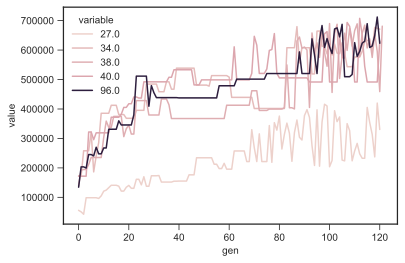

In [27]:
melted = hypervolumes.melt(id_vars='gen').astype('float')
melted['gen'] = pd.to_numeric(melted['gen'],downcast='float')
melted['value'] = pd.to_numeric(melted['value'],downcast='float')
sns.lineplot(data=melted,hue='variable',x='gen',y='value')

In [180]:
melted.to_sql(name='hypervolumes',con=engine,index=True,if_exists="replace")

### No-GW-Penalty Front F1 & F2

In [23]:
front_nogw = pd.read_csv(os.path.join(calvin_dir,'my-models','calvin-lf','results','total_costs_nogw.csv'))

In [24]:
front_sample = front_sample.merge(front_nogw,how='left',on='id',suffixes=('','-NoGW'))

Text(0, 0.5, 'NoGW Residual [MAF/yr]')

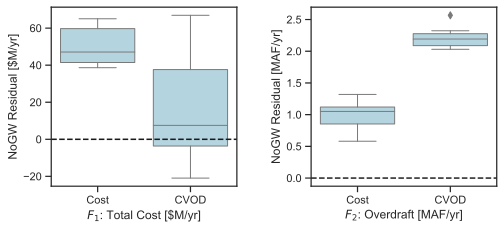

In [25]:
sns.set(rc={'figure.figsize':(8,3.3)},font_scale=1)
sns.set_style("ticks")
from matplotlib.collections import LineCollection

ncols=2
nrows=1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
plt.subplots_adjust(wspace=0.4)

data = front_sample.loc[front_sample.type!='OD']
sns.boxplot(x=data['type'],
                y=data['f1-NoGW']-data['f1'],linewidth=1,
                palette=['lightblue','lightblue'],ax=axes[0])

sns.boxplot(x=data['type'],
                y=data['f2-NoGW']-data['f2'],linewidth=1,
                palette=['lightblue','lightblue'],ax=axes[1])

# axes[0].legend('')
# axes[1].legend(title='')
axes[0].axhline(0,linestyle='dashed',color='k')
axes[1].axhline(0,linestyle='dashed',color='k')
axes[0].set_xlabel('$F_1$: Total Cost [\$M/yr]')
axes[0].set_ylabel('NoGW Residual [\$M/yr]')
axes[1].set_xlabel('$F_2$: Overdraft [MAF/yr]')
axes[1].set_ylabel('NoGW Residual [MAF/yr]')
# plt.savefig(os.path.join(fig_dir,'NoGW Residuals.pdf'),dpi=300, bbox_inches="tight");

### CS-II w/ Front F1 & F2

In [26]:
front_csii = pd.read_csv(os.path.join(calvin_dir,'my-models','calvin-lf-fs','results','total_costs.csv'))

In [27]:
front_sample = front_sample.merge(front_csii,how='left',on='id',suffixes=('','-CSII'))

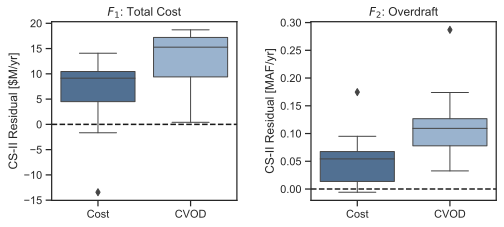

In [28]:
sns.set(rc={'figure.figsize':(8,3.3)},font_scale=1)
sns.set_style("ticks")
from matplotlib.collections import LineCollection

ncols=2
nrows=1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
plt.subplots_adjust(wspace=0.4)

df = front_sample.loc[front_sample.type!='OD']

sns.boxplot(x=df['type'],
                y=df['f1-CSII']-df['f1'],linewidth=1,
                palette=['#466f9d','#91b3d7'],ax=axes[0])

sns.boxplot(x=df['type'],
                y=df['f2-CSII']-df['f2'],linewidth=1,
                palette=['#466f9d','#91b3d7'],ax=axes[1])

# axes[0].legend('')
# axes[1].legend(title='')
axes[0].axhline(0,linestyle='dashed',color='k')
axes[1].axhline(0,linestyle='dashed',color='k')
axes[0].set_title('$F_1$: Total Cost')
axes[0].set_xlabel('')
axes[0].set_ylabel('CS-II Residual [\$M/yr]')
axes[1].set_title('$F_2$: Overdraft')
axes[1].set_xlabel('')
axes[1].set_ylabel('CS-II Residual [MAF/yr]');
# plt.savefig(os.path.join(fig_dir,'CS-II Residuals.svg'),dpi=300, bbox_inches="tight");

### Build ea_select list

In [29]:
front['type'] = 'Fronts'
front_ref['type'] = 'Front-Ref'
ea_select = front.append(front_ref).append(front_sample)
ea_select['seed'] = ea_select.id.str.split('-').str[2]

In [ ]:
ea_select.to_csv('ea_select.csv')

## Reservoir Parameter Dataframes

In [30]:
def front_position_pivot(df, rtype, id):
    # pivot positions so that params are columns
    pivot = pd.pivot_table(df.loc[df['r'].str.contains(rtype)], 
                           columns='param', index=['id','r'],
                           values='value').reset_index()
    pivot = pivot.merge(df[['id','r','f1','f2']],
                        on=['id','r'],how='inner').drop_duplicates()
    return pivot

In [31]:
# # pivot surface reservoirs on all fronts
# sr_front_positions = front_position_pivot(front_positions, 'SR', 'id')

# # pivot surface reservoirs for reference front
# sr_front_ref_positions = front_position_pivot(front_ref_positions, 'SR', 'id')

# pivot ea history positions                                 
sr_positions = pd.pivot_table(eahist.loc[eahist.param!='p'],columns='param',index=['id','r'],
                              values='value').reset_index()

# pivot all groundwater history positions
gw_positions = pd.pivot_table(eahist.loc[eahist.param=='p'],columns='param',index=['id','r'],
                              values='value').reset_index()
gw_positions['p'] = gw_positions['p']*-1

### Positions to Database

In [30]:
# ea_select.set_index('id').to_sql(name='ea_select',con=engine,index=True,if_exists="replace",
#     dtype={'id': sqlalchemy.VARCHAR(length=15)})

# sr_positions.set_index(['id','r']).to_sql(name='ea_sr_positions',con=engine,index=True,if_exists="replace",
#     dtype={'id': sqlalchemy.VARCHAR(length=15),
#             'r': sqlalchemy.VARCHAR(length=15)})

# gw_positions.set_index(['id','r']).to_sql(name='ea_gw_positions',con=engine,index=True,if_exists="replace",
#     dtype={'id': sqlalchemy.VARCHAR(length=15),
#             'r': sqlalchemy.VARCHAR(length=15)})

costs.set_index('id').to_sql(name='ea_costs',con=engine,index=True,if_exists="replace",
    dtype={'id': sqlalchemy.VARCHAR(length=15)})

## Load Results to Database

### ANNUAL

#### DUALS

In [146]:
def load_duals_annual(result_dir, side, key, id):
    """lower and upper dual values"""
    duals = pd.read_csv(
        os.path.join(result_dir,'dual_{}.csv'.format(side)),
        parse_dates=True,index_col='date')
    duals.reset_index(inplace=True)
    duals.date = pd.date_range(start='10/31/1921', periods=12*82, freq='M')
    duals = duals.melt(id_vars='date')
    duals = duals[~duals["variable"].str.contains('DBUG')]
    if side =='lower':
        duals = duals.loc[duals["value"] > -1e4]
        duals['value'] = round(duals['value'],3)*-1
    else:
        duals = duals.loc[duals["value"] < 1e4]
        duals['value'] = round(duals['value'],3)
    
    duals['month'] = pd.DatetimeIndex(duals.date).month
    duals['wy'] = np.where(duals.month.isin([10,11,12]),
                      pd.DatetimeIndex(duals.date).year + 1, 
                      pd.DatetimeIndex(duals.date).year)
    if key in ['PF-Cost','PF-CVOD','PF-OD']:
        duals['freq'] = np.where(duals['value']>0,
                                     np.where(
                                         duals['variable'].isin(['SR_SHA']),
                                         np.where(duals['value']>7,1,0),
                                     np.where(
                                         duals['variable'].isin(['SR_ORO']),
                                         np.where(duals['value']>11,1,0),
                                     np.where(
                                         duals['variable'].isin(['SR_NML']),
                                         np.where(duals['value']>4,1,0),
                                     np.where(
                                         duals['variable'].isin(['SR_MCR']),
                                         np.where(duals['value']>3,1,0),
                                     np.where(
                                         duals['variable'].isin(['SR_BUL']),
                                         np.where(duals['value']>4,1,0),
                                     np.where(
                                         duals['variable'].isin(['SR_DNP']),
                                         np.where(duals['value']>5,1,0),
                                     np.where(
                                         duals['variable'].isin(['SR_FOL']),
                                         np.where(duals['value']>4,1,0),
                                     np.where(
                                         duals['variable'].isin(['SR_HTH']),
                                         np.where(duals['value']>2,1,0),
                                 1)))))))),
                                 0)
    else:
        duals['freq'] = np.where(duals['value']>0,1,0)
        
    duals = duals.loc[~((duals.variable.str.contains('^SR_+\w{3}$',regex=True)) & (duals.month==9))]

    duals = duals.groupby(['wy','variable'], as_index='false').agg(
        {'value':['mean', 'max','sum'],'freq':['max']}).reset_index()

    duals['run'] = key
    duals['id'] = id

    duals.set_index(['run','id','wy','variable'],inplace=True)
    
    duals.columns = duals.columns.droplevel([0])
    duals.columns = ['mean_annual','max_annual','sum_annual','freq']
    
    duals_stat = duals.groupby(['run','id','variable']).agg(
        {'mean_annual':['std','mean','max'], 
         'max_annual':['std','mean','max'],
         'sum_annual':['std','mean','max'],
         'freq':['sum']})
    
    duals_stat.columns = duals_stat.columns.droplevel([0])
    duals_stat.columns = ['std_mean_annual','avg_mean_annual','max_mean_annual',
                          'std_max_annual','avg_max_annual','max_max_annual',
                          'std_sum_annual','avg_sum_annual','max_sum_annual',
                          'frequency']
    
    return duals,duals_stat

In [150]:
# load to database
side = 'lower'
sheet_df = pd.DataFrame()
for key in result_dirs:
    if key in ['PF-Cost','PF-CVOD','PF-OD','Myopic']:
        data, data_stat = load_duals_annual(result_dirs[key], side, key, key)
        sheet_df = sheet_df.append(data_stat)
    elif key not in ['Front-Ref']:
        for key_type in ['Cost','CVOD','OD']:
            if key =='NoPGW': continue
            cosvf_solved = front_sample.loc[front_sample.type==key_type].id
            for id in cosvf_solved:
                data, data_stat = load_duals_annual(
                    os.path.join(result_dirs[key],'front-{}'.format(id)), side, key+'-'+key_type, id=id)
                sheet_df = sheet_df.append(data_stat)

sheet_df.to_sql(name='annual_duals_{}'.format(side), 
                con=engine, index=True, if_exists="replace",
    dtype={'run': sqlalchemy.VARCHAR(length=15), 
            'id': sqlalchemy.VARCHAR(length=15),
            'variable': sqlalchemy.VARCHAR(length=50)})

#### SEP STORAGE

In [36]:
def load_lf_sep_storage(result_dir,key,id,kcs,lb):
    """limited foresight sep storage"""
    data = pd.read_csv(os.path.join(result_dir,'eop_storage.csv'),
        parse_dates=True,index_col='date')
    data.reset_index(inplace=True)
    data.date = pd.date_range(start='9/30/1922', periods=82, freq='Y')
    data = data.melt(id_vars='date')
    data['kcs'] = data['variable'].map(kcs)
    data['lb'] = data['variable'].map(lb)
    data['value_kcs'] = (data['value']-data['lb'])/data['kcs']
    data.drop('kcs',axis=1,inplace=True)
    data['run'] = key
    data['id'] = id
    data['month'] = pd.DatetimeIndex(data.date).month
    data['wy'] = pd.DatetimeIndex(data.date).year
    data.set_index(['run','wy','month','variable'],inplace=True)
    return data
def load_pf_sep_storage(result_dir,key,id,kcs,lb):
    """perfect foresight sep storage"""
    data = pd.read_csv(os.path.join(result_dir,'storage.csv'),
        parse_dates=True,index_col='date')
    data.reset_index(inplace=True)
    data.date = pd.date_range(start='10/31/1921', periods=12*82, freq='M')
    data = data.melt(id_vars='date')
    data['run'] = key
    data['id'] = id
    data['month'] = pd.DatetimeIndex(data.date).month
    data = data.loc[data.month==9]
    data['kcs'] = data['variable'].map(kcs)
    data['lb'] = data['variable'].map(lb)
    data['value_kcs'] = (data['value']-data['lb'])/data['kcs']
    data.drop('kcs',axis=1,inplace=True)
    data['wy'] = pd.DatetimeIndex(data.date).year
    data.set_index(['run','wy','month','variable'],inplace=True)
    return data


In [37]:
# load to db
sheet_df = pd.DataFrame()
for key in result_dirs:
    if key in ['PF-Cost','PF-CVOD','PF-OD','Myopic']:
        data = load_pf_sep_storage(result_dirs[key],key,key,kcs,lb)
        sheet_df = sheet_df.append(data)
    elif key not in ['Front-Ref']:
        for key_type in ['Cost','CVOD','OD']:
            if key =='NoPGW' and key_type=='OD': continue
            cosvf_solved = front_sample.loc[front_sample.type==key_type].id
            for id in cosvf_solved:
                data = load_lf_sep_storage(os.path.join(result_dirs[key],'front-{}'.format(id)), key+'-'+key_type, id, kcs, lb)
                sheet_df = sheet_df.append(data)

# sheet_df.to_sql(name='{}'.format('annual_eop_storage'),
#                 con=engine, index=True, if_exists="replace",
#     dtype={'run': sqlalchemy.VARCHAR(length=15), 
#             'id': sqlalchemy.VARCHAR(length=15), 
#             'wy': sqlalchemy.INTEGER, 
#             'variable': sqlalchemy.VARCHAR(length=30), 
#             'date': sqlalchemy.DateTime(), 
#             'value': sqlalchemy.types.Float(precision=3, asdecimal=True)})

In [38]:
sep_storage = sheet_df.copy()
sep_storage.reset_index(inplace=True)
# sep_storage_knee = sep_storage.loc[~sep_storage.run.isin(['pf','pf-od','pf-od-cv','myopic','front'])]
sep_storage_front = sep_storage.loc[sep_storage.run.isin(['Front-Cost','Front-CVOD','Front-OD'])]
# sep_storage_front = sep_storage.loc[sep_storage.run.isin(['Front'])]

In [39]:
len(sep_storage_front[['run','id']].drop_duplicates())

26

#### Monthly Storage

In [213]:
def load_monthly_storage(result_dir, key, id):
    """default annual result load"""
    df = pd.read_csv(os.path.join(result_dir,'{}.csv'.format('storage')),
        parse_dates=True,index_col='date')
    df.reset_index(inplace=True)
    df.date = pd.date_range(start='10/31/1921', periods=12*82, freq='M')
    df = df.melt(id_vars='date')
    
    # isolate SR links
    df = df[(df["variable"].isin(sr_ns_list))]
    
    df['month'] = pd.DatetimeIndex(df.date).month

    df['wy'] = np.where(pd.DatetimeIndex(df.date).month.isin([10,11,12]),
                          pd.DatetimeIndex(df.date).year + 1, 
                          pd.DatetimeIndex(df.date).year)

    df['run'] = key
    df['id'] = str(id)

    df.set_index(['run','id','wy','month','variable'],inplace=True)
    df.drop('date',axis=1,inplace=True)
    
    return df

In [216]:
# load to database
sheet_df = pd.DataFrame()
for key in result_dirs:
    if key in ['PF-Cost','PF-CVOD','PF-OD','Myopic']:
        data = load_monthly_storage(result_dirs[key], key, id=key)
        sheet_df = sheet_df.append(data)
    elif key not in ['Front-Ref']:
        for key_type in ['Cost','CVOD','OD']:
            if key =='NoPGW' and key_type=='OD': continue
            cosvf_solved = front_sample.loc[front_sample.type==key_type].id
            for id in cosvf_solved:
                try:
                    data = load_monthly_storage(
                            os.path.join(result_dirs[key],'front-{}'.format(id)), 
                            key, id=id)
                    sheet_df = sheet_df.append(data)
                except:
                    print(id + ' does not exist')
                    continue
        
sheet_df.to_sql(name='sr_storage',
                con=engine, index=True, if_exists="replace",
    dtype={'run': sqlalchemy.VARCHAR(length=10), 
            'id': sqlalchemy.VARCHAR(length=15),
            'wy': sqlalchemy.INTEGER,  
            'month': sqlalchemy.INTEGER,  
            'variable': sqlalchemy.VARCHAR(length=50),
            'value': sqlalchemy.types.Float(precision=3, asdecimal=True)})



#### OVERDRAFT

In [44]:
def load_overdraft(result_dir, key, id):
    """default annual result load"""
    df = pd.read_csv(os.path.join(result_dir,'{}.csv'.format('storage')),
        parse_dates=True,index_col='date')
    df = df.melt()
    melt_od = df.loc[df.variable.str.contains('GW_')].groupby(['variable'], sort=False).last() \
            - df.loc[df.variable.str.contains('GW_')].groupby(['variable'], sort=False).first()
    
    melt_od_max = df.loc[df.variable.str.contains('GW_')].groupby(['variable'], sort=False).min() \
            - df.loc[df.variable.str.contains('GW_')].groupby(['variable'], sort=False).first()
    
    melt_od.value = np.where(melt_od.value>0,0,melt_od.value)
    melt_od = melt_od.join(melt_od_max,rsuffix='_max') 
    melt_od.reset_index(inplace=True)
    melt_od['run'] = key
    melt_od['id'] = id
    melt_od.set_index(['run','id','variable'],inplace=True)
    
    return melt_od

In [45]:
# load to database
sheet_df = pd.DataFrame()
for key in result_dirs:
    if key in ['PF-Cost','PF-CVOD','PF-OD','Myopic']:
        data = load_overdraft(result_dirs[key], key, key)
        sheet_df = sheet_df.append(data)
    elif key not in ['Front-Ref']:
        for key_type in ['Cost','CVOD','OD']:
            if key =='NoPGW' and key_type=='OD': continue
            cosvf_solved = front_sample.loc[front_sample.type==key_type].id
            for id in cosvf_solved:
                data = load_overdraft(os.path.join(result_dirs[key],'front-{}'.format(id)), key+'-'+key_type, id=id)
                sheet_df = sheet_df.append(data)

# sheet_df.to_sql(name='gw_overdraft',
#                 con=engine, index=True, if_exists="replace",
#     dtype={'run': sqlalchemy.VARCHAR(length=15), 
#             'id': sqlalchemy.VARCHAR(length=15),
#             'variable': sqlalchemy.VARCHAR(length=50),
#             'value': sqlalchemy.types.Float(precision=3, asdecimal=True),
#             'value_max': sqlalchemy.types.Float(precision=3, asdecimal=True)})

In [46]:
gw_overdraft = sheet_df.copy()
gw_overdraft.reset_index(inplace=True)

In [47]:
gw_overdraft['value'] = gw_overdraft['value'] / 82

In [48]:
gw_overdraft_pf = gw_overdraft.loc[gw_overdraft.run=='PF-Cost']
gw_overdraft_nopgw = gw_overdraft.loc[gw_overdraft.run=='NoPGW-Cost']
gw_overdraft_front = gw_overdraft.loc[gw_overdraft.run.isin(['Front-Cost','Front-CVOD'])]

In [49]:
gw_overdraft_nopgw = gw_overdraft_nopgw.groupby('variable',as_index=False).value.mean()

In [50]:
gw_overdraft_front.insert(4,'type',value = np.where(gw_overdraft_front.run=='Front-Cost','LF-Cost','LF-CVOD'))

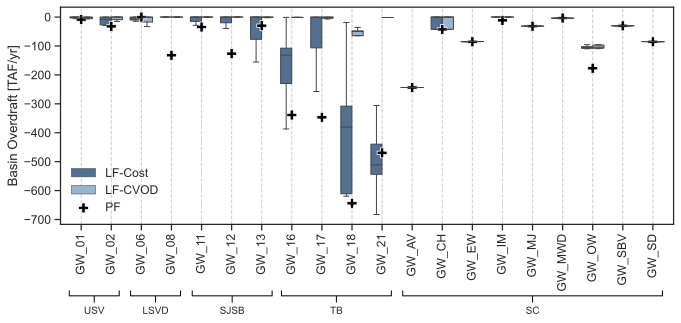

In [51]:
sns.set(rc={'figure.figsize':(11,4)},font_scale=1.1)
sns.set_style("ticks")

basins=['GW_01','GW_02','GW_06','GW_08','GW_11','GW_12','GW_13','GW_16','GW_17','GW_18','GW_21',
           'GW_AV','GW_CH','GW_EW','GW_IM','GW_MJ','GW_MWD','GW_OW','GW_SBV','GW_SD']

df = gw_overdraft_front.copy()
sns.boxplot(data=df.loc[df.variable.isin(basins)],x='variable',y='value',hue='type',palette=['#466f9d','#91b3d7'],
            fliersize=0,linewidth=1,width=0.75)
df = gw_overdraft_pf.copy()
sns.scatterplot(data=df.loc[df.variable.isin(basins)],x='variable',y='value',color='black',marker='P',label='PF',s=100)
# df = gw_overdraft_nopgw.copy()
# sns.scatterplot(data=df.loc[df.variable.isin(basins)],x='variable',y='value',color='brown',marker='*',label='$P_{GW}=0$',s=170)

plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Basin Overdraft [TAF/yr]');
plt.legend(title='')
# plt.axhline(0,c='k',zorder=1,linestyle='--')
plt.grid(axis='x',linestyle='--')


plt.annotate('USV', xy=(0.055, -0.32), xytext=(0.055, -0.4), xycoords='axes fraction', 
            fontsize=10, ha='center', va='center',
#             bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=0.5', color='black', lw=1))

plt.annotate('LSVD', xy=(.155, -0.32), xytext=(0.155, -0.4), xycoords='axes fraction', 
            fontsize=10, ha='center', va='center',
#             bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=0.5', color='black', lw=1))

plt.annotate('SJSB', xy=(0.28, -0.32), xytext=(0.28, -0.4), xycoords='axes fraction', 
            fontsize=10, ha='center', va='center',
#             bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=4, lengthB=0.5', color='black', lw=1))
plt.annotate('TB', xy=(0.45, -0.32), xytext=(0.45, -0.4), xycoords='axes fraction', 
            fontsize=10, ha='center', va='center',
#             bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=5.5, lengthB=0.5', color='black', lw=1))
plt.annotate('SC', xy=(0.77, -0.32), xytext=(0.77, -0.4), xycoords='axes fraction', 
            fontsize=10, ha='center', va='center',
#             bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=13, lengthB=0.5', color='black', lw=1));

# plt.savefig(os.path.join(fig_dir,'GW-OD-boxplot-zone-compare.svg'),dpi=300, bbox_inches="tight");

#### SHORTAGE, OP COSTS, & FLOW

In [40]:
def load_annual_default(result_dir, sheet, key, id, demands, portfolio, operation_groups, debug=False):
    """default annual result load"""
    df = pd.read_csv(os.path.join(result_dir,'{}.csv'.format(sheet)),
        parse_dates=True,index_col='date')
    df.reset_index(inplace=True)
    if sheet=='evaporation': 
        if key not in ['PF-Cost','PF-CVOD','PF-OD']: 
            df.date = pd.date_range(start='10/31/1921', periods=11*82, freq='M')
        else:
            df = df.append(pd.Series(name='9/30/2003',dtype='float64'))
            df.date = pd.date_range(start='10/31/1921', periods=12*82, freq='M')
    else:
        df.date = pd.date_range(start='10/31/1921', periods=12*82, freq='M')
        
    df = df.melt(id_vars='date')
    
    # remove or isolate debug links
    if debug==False: 
        df = df[~df["variable"].str.contains('DBUG')]
    else:
        df = df[(df["variable"].str.contains('DBUG'))]

    df['wy'] = np.where(pd.DatetimeIndex(df.date).month.isin([10,11,12]),
                          pd.DatetimeIndex(df.date).year + 1, 
                          pd.DatetimeIndex(df.date).year)

    df1 = df.groupby(['wy','variable'], as_index='false').agg(
        {'value':'sum'}).reset_index()
    
    if 'shortage' in sheet:
        df2 = df.loc[~df.variable.isin(demands.region_type.unique())]
    elif 'flow' in sheet:
        df2 = df.loc[~df.variable.isin(portfolio.region_supplytype_type.unique())]
    else: df2 = df.copy()
    df2 = df2.groupby(['wy'], as_index='false').agg(
        {'value':'sum'}).reset_index()
    df2['variable'] = 'all_links'
    
    if 'shortage' in sheet and 'pf' not in key:
        dfmerge = df1.merge(demands,left_on='variable',right_on='link')
        dfmerge['variable'] = dfmerge['region_type']
        df3 = dfmerge.groupby(['wy','variable'], as_index='false').agg(
            {'value':'sum'}).reset_index()
        
    elif 'flow' in sheet and 'pf' not in key:
        dfmerge = df1.merge(portfolio,left_on='variable',right_on='link')
        dfmerge['variable'] = dfmerge['region_supplytype_type']
        df3 = dfmerge.groupby(['wy','variable'], as_index='false').agg(
            {'value':'sum'}).reset_index()
        
    elif 'operation' in sheet:
        dfmerge = df1.merge(operation_groups,left_on='variable',right_on='link')
        dfmerge['variable'] = dfmerge['group']
        df3 = dfmerge.groupby(['wy','variable'], as_index='false').agg(
            {'value':'sum'}).reset_index()
    else:
        df3 = df2.drop(df2.index) # empty dataframe
    
    df1['run'], df2['run'], df3['run'] = key, key, key
    df1['id'], df2['id'], df3['id'] = id, id, id
    
    def df_reset_columns(df):
        df.set_index(['run','id','wy','variable'],inplace=True)
        return df
    
    df1 = df_reset_columns(df1)
    df2 = df_reset_columns(df2)
    df3 = df_reset_columns(df3)

    df = df1.append(df2).append(df3)
    
    df_stats = df.groupby(['run','id','variable']).agg(
        {'value':['sum','mean', 'skew', 'std',  'min', 'max']})
    if 'cost' in sheet: df_stats = df_stats/1e3
    
    return df, df_stats



In [ ]:
def load_monthly_default(result_dir, sheet, key, id, debug=False):
    """default annual result load"""
    df = pd.read_csv(os.path.join(result_dir,'{}.csv'.format(sheet)),
        parse_dates=True,index_col='date')
    df.reset_index(inplace=True)
    df.date = pd.date_range(start='10/31/1921', periods=12*82, freq='M')
    df = df.melt(id_vars='date')
    
    # remove or isolate debug links
    if debug==False: 
        df = df[~df["variable"].str.contains('DBUG')]
    else:
        df = df[(df["variable"].str.contains('DBUG'))]

    df['mo'] = pd.DatetimeIndex(df.date).month

    df = df.groupby(['mo','variable']).agg(
        {'value':['mean','max','min','std','skew']})
    
    df['run']=key
    df['id']=id
    
    df.set_index((['run','id','variable']))
    
    return df



In [49]:
front_sample.sort_values(by='id')

,id,f1,f2,type,ind,seed
0,102-50-38,5367.341858,2.010800,Cost,50,38
1,111-55-96,5440.679200,0.704180,CVOD,55,96
10,116-6-27,5888.354857,0.127453,OD,6,27
7,119-23-40,5406.344879,0.758004,CVOD,23,40
8,120-14-96,5378.705916,2.196114,Cost,14,96
9,120-15-40,5412.400372,0.716968,CVOD,15,40
10,120-22-40,5417.730520,0.692068,CVOD,22,40
9,120-25-96,5380.564824,2.070780,Cost,25,96
12,120-62-96,5381.039814,1.715852,Cost,62,96
15,120-86-27,5897.290308,0.126297,OD,86,27


In [ ]:
# load to database
for sheet in ['flow']:
# for sheet in ['shortage_cost','shortage_volume']:
# for sheet in ['operation_costs']:
    sheet_df = pd.DataFrame()
    sheet_df_wy = pd.DataFrame()
    for key in result_dirs:
        if key in ['PF-Cost','PF-CVOD','PF-OD','Myopic']:
            data, data_stats = load_annual_default(result_dirs[key], sheet, key, key, demands, portfolio, operation_groups)
            sheet_df = sheet_df.append(data_stats)
            sheet_df_wy = sheet_df_wy.append(data)
        elif key not in ['Front-Ref']:
            for key_type in ['Cost','CVOD','OD']:
                if key =='NoPGW' and key_type=='OD': continue
                cosvf_solved = front_sample.loc[front_sample.type==key_type].id
                for id in cosvf_solved:
                    data, data_stats = load_annual_default(
                        os.path.join(result_dirs[key],'front-{}'.format(id)), 
                        sheet, key+'-'+key_type, id, demands, portfolio, operation_groups)
                    sheet_df = sheet_df.append(data_stats)
                    sheet_df_wy = sheet_df_wy.append(data)
            
    sheet_df.columns = sheet_df.columns.droplevel([0])
    sheet_df_wy.reset_index(inplace=True)
    sheet_df_wy = sheet_df_wy.loc[(sheet_df_wy.variable.isin(portfolio['region_supplytype_type'].unique())) | 
                                 (sheet_df_wy.variable.isin(['D862B-PMP_Edmons'])) | 
                                 (sheet_df_wy.variable.isin(['C309-D59']))]
#     sheet_df_wy = sheet_df_wy.loc[sheet_df_wy.variable.isin(['all_links','LSVD_ag','LSVD_urban','SC_ag','SC_urban','SJSB_ag','SJSB_urban','TB_ag','TB_urban','USV_ag','USV_urban'])]
    sheet_df_wy.drop_duplicates(subset=['run','id','variable','wy'],inplace=True)
    sheet_df_wy.set_index(['run','id','wy','variable'],inplace=True)
    sheet_df_wy.to_sql(name='annual_{}'.format(sheet),
                    con=engine, index=True, if_exists="replace",
        dtype={'run': sqlalchemy.VARCHAR(length=15), 
                'id': sqlalchemy.VARCHAR(length=15),
                'variable': sqlalchemy.VARCHAR(length=50)})
#     sheet_df.to_sql(name='annual_stats_{}'.format(sheet),
#                     con=engine, index=True, if_exists="replace",
#         dtype={'run': sqlalchemy.VARCHAR(length=15), 
#                 'id': sqlalchemy.VARCHAR(length=15),
#                 'variable': sqlalchemy.VARCHAR(length=50),
#                 'sum': sqlalchemy.types.Float(precision=3, asdecimal=True),
#                 'mean': sqlalchemy.types.Float(precision=3, asdecimal=True),
#                 'min': sqlalchemy.types.Float(precision=3, asdecimal=True),
#                 'max': sqlalchemy.types.Float(precision=3, asdecimal=True),
#                 'std': sqlalchemy.types.Float(precision=3, asdecimal=True),
#                 'skew': sqlalchemy.types.Float(precision=3, asdecimal=True)})


In [57]:
sheet_df_wy.to_sql(name='annual_{}'.format(sheet),
                    con=engine, index=True, if_exists="replace",
        dtype={'run': sqlalchemy.VARCHAR(length=15), 
                'id': sqlalchemy.VARCHAR(length=15),
                'variable': sqlalchemy.VARCHAR(length=50)})

In [ ]:
# load to database
for sheet in ['flow']:
# for sheet in ['operation_costs']:
    sheet_df = pd.DataFrame()
    for key in result_dirs:
        if key in ['PF-Cost','PF-CVOD','PF-OD','Myopic']:
            data = load_monthly_default(result_dirs[key], sheet, key, key)
            sheet_df = sheet_df.append(data)
        elif key not in ['Front-Ref']:
            for key_type in ['Cost','CVOD','OD']:
                if key =='NoPGW' and key_type=='OD': continue
                cosvf_solved = front_sample.loc[front_sample.type==key_type].id
                for id in cosvf_solved:
                    data = load_monthly_default(
                        os.path.join(result_dirs[key],'front-{}'.format(id)), 
                        sheet, key+'-'+key_type, id)
                    sheet_df = sheet_df.append(data)
            
    sheet_df.columns = sheet_df.columns.droplevel([0])
    sheet_df.to_sql(name='monthly_stats_{}'.format(sheet),
                    con=engine, index=True, if_exists="replace",
        dtype={'run': sqlalchemy.VARCHAR(length=15), 
                'id': sqlalchemy.VARCHAR(length=15),
                'variable': sqlalchemy.VARCHAR(length=50),
                'mean': sqlalchemy.types.Float(precision=3, asdecimal=True),
                'min': sqlalchemy.types.Float(precision=3, asdecimal=True),
                'max': sqlalchemy.types.Float(precision=3, asdecimal=True),
                'std': sqlalchemy.types.Float(precision=3, asdecimal=True),
                'skew': sqlalchemy.types.Float(precision=3, asdecimal=True)})

#### DEBUG

In [ ]:
# load to database
sheet_df = pd.DataFrame()
for key in result_dirs:
    if key in ['PF-Cost','PF-CVOD','PF-OD','Myopic']:
        data, data_stats = load_annual_default(result_dirs[key], 
                                   'flow', key, key, demands, portfolio, operation_groups, debug=True)
        sheet_df = sheet_df.append(data)
    elif key not in ['Front-Ref','CSII']:
        for key_type in ['Cost','CVOD','OD']:
            if key =='NoPGW' and key_type=='OD': continue
            cosvf_solved = front_sample.loc[front_sample.type==key_type].id
            for id in cosvf_solved:
                data, data_stats = load_annual_default(
                    os.path.join(result_dirs[key],'front-{}'.format(id)), 
                    'flow', key+'-'+key_type, id, demands, portfolio, operation_groups, debug=True)
                sheet_df = sheet_df.append(data)

sheet_df.to_sql(name='annual_flow_debug',
                con=engine, index=True, if_exists="replace",
    dtype={'run': sqlalchemy.VARCHAR(length=15), 
            'id': sqlalchemy.VARCHAR(length=15),
            'wy': sqlalchemy.INTEGER,  
            'variable': sqlalchemy.VARCHAR(length=50),
            'sum': sqlalchemy.types.Float(precision=3, asdecimal=True)})

# Supplement COSVF Params with Results

## Storages for RP & expected value penalties

In [48]:
r_stats = pd.read_csv('../spreadsheets/r_stats.csv')

In [49]:
r_stats.head()

,Unnamed: 0,sr,inflow_u,inflow_sd,i_nodes,sr_k,sr_k_u,sr_k_sd
0,0,GW_01,94.397121,56.931208,"INFLOW, HGR01",1.000000e+12,1.059354e+10,1.756506e+10
1,0,GW_02,311.360372,106.643091,"INFLOW, HGR02",1.000000e+12,3.211713e+09,9.377073e+09
2,0,GW_03,229.752506,72.129287,"INFLOW, HGR03",1.000000e+12,4.352510e+09,1.386399e+10
3,0,GW_04,286.664318,140.328944,"INFLOW, HGR04",1.000000e+12,3.488401e+09,7.126114e+09
4,0,GW_05,429.456926,125.582017,"INFLOW, HGR05",1.000000e+12,2.328522e+09,7.962924e+09


In [50]:
def rp(a,b,c,e_s,cosv):
    p = np.poly1d([a, b, c])
    rp = e_s-(p-cosv).roots[1]
    return rp

csvf = lambda x,a,b,c: a*x**2 + b*x + c
ap = lambda lb,a,b: -1*2*a/((2*lb*a)+b)

In [51]:
df_positions = front_positions.copy() #front_u_zone1_positions #knee_positions
# sep_storage = sep_storage_front.copy()

In [52]:
# pivot surface reservoirs for reference front
sr_zone_positions = front_position_pivot(eahist.loc[eahist.id.isin(front_sample.id)], 'SR', 'id')
# sr_zone_positions.sort_values(['r','f2'],inplace=True)

In [53]:
sr_zone_positions['lb'] = sr_zone_positions['r'].map(lb)
sr_zone_positions['ub'] = sr_zone_positions['r'].map(ub)
x,y,sr_zone_positions['a'], sr_zone_positions['b'], sr_zone_positions['c']= \
    zip(*sr_zone_positions.apply(lambda x: calvin.cosvf_fit_from_params(
        pmin=x['pmin'], pmax=x['pmax'], eop_min=x['lb'], eop_max=x['ub'], k_count=100), axis=1))
sr_zone_positions['pavg'] = (sr_zone_positions['pmax'] + sr_zone_positions['pmin'])/2*-1
sr_zone_positions['pmax'] = sr_zone_positions['pmax'] *-1
sr_zone_positions['pmin'] = sr_zone_positions['pmin'] *-1
sr_zone_positions['klb_ap'] = sr_zone_positions.apply(lambda x: ap(0, x['a'], x['b']), axis=1)

In [54]:
sep_storage_sr = sep_storage_front.merge(sr_zone_positions[['id','r','a','b','c']],left_on=['id','variable'],right_on=['id','r'])
sep_storage_sr['E[p(s)]'] = sep_storage_sr.apply(lambda x: csvf(x['value'], x['a'], x['b'], x['c']), axis=1)

In [55]:
sep_storage_mean = sep_storage_sr.groupby(['id','r'],as_index=False).agg(
    {'value':'mean','E[p(s)]':'mean','a':'mean','b': 'mean','c':'mean'})
sep_storage_mean['P(E[S])'] = sep_storage_mean.apply(lambda x: csvf(x['value'], x['a'], x['b'], x['c']), axis=1)
sep_storage_mean['P(E[S])-E[p(s)]'] = sep_storage_mean['P(E[S])'] - sep_storage_mean['E[p(s)]']
sep_storage_mean['RP'] = sep_storage_mean.apply(lambda x: rp( x['a'], x['b'], x['c'], x['value'], x['E[p(s)]']), axis=1)

In [56]:
sr_zone_positions = sr_zone_positions.merge(
    sep_storage_mean[['id','r','value','E[p(s)]','P(E[S])','P(E[S])-E[p(s)]','RP']],on=['id','r'])

sr_zone_positions['RP:Kub'] = sr_zone_positions['RP']/(sr_zone_positions['ub']-sr_zone_positions['lb'])
sr_zone_positions['Pmarg(E[S])'] =2*sr_zone_positions['value']*sr_zone_positions['a']+sr_zone_positions['b']
sr_zone_positions['Pmarg(E[S])'] = sr_zone_positions['Pmarg(E[S])'] *-1
sr_zone_positions['E[S]/Kcs'] = (sr_zone_positions['value']-sr_zone_positions['lb'])/(sr_zone_positions['ub']-sr_zone_positions['lb'])

In [57]:
sr_zone_positions = sr_zone_positions.merge(front_sample[['id','type']],on='id')

In [58]:
sr_zone_positions = sr_zone_positions.merge(r_stats,left_on='r',right_on='sr',how='left')

In [59]:
sr_zone_positions_cost = sr_zone_positions.loc[sr_zone_positions.type=='Cost'].copy()
sr_zone_positions_cvod = sr_zone_positions.loc[sr_zone_positions.type=='CVOD'].copy()
sr_zone_positions_all = sr_zone_positions.loc[sr_zone_positions.type.isin(['CVOD','Cost'])].copy()

In [ ]:
# sr_cosvf.set_index(['id','R']).to_sql(name='sr_cosvf_stat',
#                 con=engine, index=True, if_exists="replace",
#                 dtype={'id': sqlalchemy.VARCHAR(length=15), 
#                 'R': sqlalchemy.VARCHAR(length=15)})

In [ ]:
sr_zone_positions.to_sql(name='sr_select_positions',
                con=engine, index=True, if_exists="replace",
    dtype={'type': sqlalchemy.VARCHAR(length=15), 
            'id': sqlalchemy.VARCHAR(length=15),
            'r': sqlalchemy.VARCHAR(length=15)})

## PF, Myopic, and CS-II fixed totals

In [33]:
#pf wsip 1995
pf_f1f2 = [5205,2.87]

#no-gw-overdraft-CV
pf_od_cv_f1f2 = [5251,0.73]

#no-gw-overdraft
pf_od_f1f2 = [5814,0.01]

# myopic
myopic_f1f2 = [5540,3.08]

# Plotting

## Plot Pareto Front

In [ ]:
# front_ind_colors = sns.cubehelix_palette(start=0, rot=0.5, dark=0.3, light=0.9, 
#                                          n_colors=len(front)).as_hex()
# front_u_zone1_ind_colors = sns.cubehelix_palette(start=0, rot=0.5, dark=0.3, light=0.9, 
#                                          n_colors=len(front_u_zone1_positions.id.unique())).as_hex()
# front_ref_ind_colors = sns.cubehelix_palette(start=0, rot=0.5, dark=0.3, light=0.9, 
#                                              n_colors=len(front_ref)).as_hex()
# front_colors = sns.cubehelix_palette(start=0, rot=0.5, dark=0.3, light=0.6, 
#                                      n_colors=len(seeds)).as_hex()

Text(0.27, 0.88, '$P_{GW}=0$')

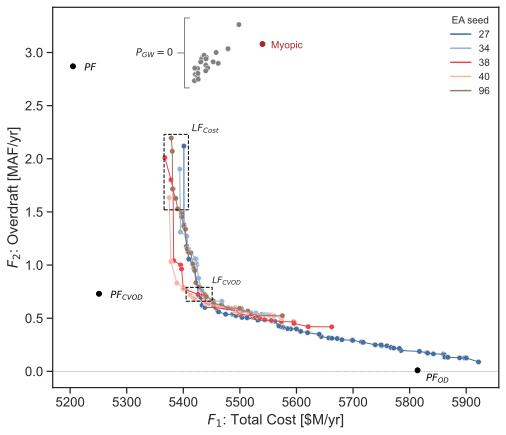

In [35]:
sns.set(rc={'figure.figsize':(8,7)})
sns.set(font_scale=1.2,style='ticks')

# pf and 
plt.plot(pf_f1f2[0],pf_f1f2[1],'o',c='black',markersize=5)
plt.text(pf_f1f2[0]+20,pf_f1f2[1]-0.04,'$PF$',fontsize='x-small',color='black')

# pf gw
plt.plot(pf_od_f1f2[0],pf_od_f1f2[1],'o',c='black',markersize=5)
plt.text(pf_od_f1f2[0]+15,pf_od_f1f2[1]-0.1,'$PF_{OD}$',fontsize='x-small',color='black')

# pf gw CV
plt.plot(pf_od_cv_f1f2[0],pf_od_cv_f1f2[1],'o',c='black',markersize=5)
plt.text(pf_od_cv_f1f2[0]+20,pf_od_cv_f1f2[1]-0.04,'$PF_{CVOD}$',fontsize='x-small',color='black')

# myopic
plt.plot(myopic_f1f2[0],myopic_f1f2[1],'o',c='brown',markersize=5)
plt.text(myopic_f1f2[0]+15,myopic_f1f2[1]-0.04,'Myopic',fontsize='x-small',color='brown')


# dominated
dominated = eahist.groupby(['id'],as_index=False).aggregate({'f1':'mean', 'f2':'mean'})
dominated['seed'] = dominated.id.str.split('-').str[2].astype(int)
dominated = dominated.loc[dominated.seed==38]
# plt.plot(dominated.f1,dominated.f2, 'x', markersize=5, c='0.85', alpha=0.2, label='', zorder=0)
# plt.plot(dominated.f1[1],dominated.f2[1], 'x', markersize=5, c='0.5', alpha=1, label='COSVF: dominated\n(seed = 38)', zorder=0)
# plt.plot(zone1.f1,zone1.f2, '.', markersize=5, c='k', alpha=0.8, label='COSVF: Zone-1 (n={})'.format(len(zone1)), zorder=0)
# plt.plot(zone2.f1,zone2.f2, '.',  markersize=20, c='orange', alpha=0.5, label='COSVF: Knee (n={})'.format(len(knee)), zorder=0)


# fronts
palette = ['#466f9d','#91b3d7','#eb444a','#f4b5a2','#9d7660']
nondominated = front.copy()
nondominated['seed'] = nondominated.id.str.split('-').str[2]
nondominated = nondominated.loc[nondominated.seed!=str(4)].sort_values('seed')
sns.lineplot(data=nondominated,x='f1',y='f2', hue='seed', lw=1, alpha=1, palette=palette)
sns.scatterplot(data=nondominated,x='f1',y='f2', hue='seed', s=30, alpha=1, edgecolor='white', palette=palette,legend=False)

# nondominated = nondominated.sort_values('f1')
# nondominated_best = nondominated.iloc[0]
# plt.scatter(nondominated_best.f1,nondominated_best.f2, s=120, color='red', marker='*', label='Best-Cost')

# nondominated = front_ref.copy()
# nondominated['seed'] = nondominated.id.str.split('-').str[2]
# sns.scatterplot(data=nondominated,x='f1',y='f2', lw=0.5, alpha=1, color='k')
# sns.scatterplot(data=nondominated,x='f1',y='f2',  s=20, alpha=1, edgecolor='white', palette='Set1',legend=False)

# front no-gw-penalty
df = front_sample.loc[front_sample.type!='OD']
sns.scatterplot(data=df,x='f1-NoGW',y='f2-NoGW', s=30, alpha=1, color='grey', edgecolor='white')
# sns.scatterplot(data=front_nogw.iloc[0:1],x='f1',y='f2', s=160, alpha=1, color='red', edgecolor='white', marker='*', label='$P_{GW}=0$\n(Best-Cost)')
# plt.text(front_nogw.f1[0]+20,front_nogw.f2-0.04,'$P_{GW}=0$',fontsize='x-small',color='brown')

# cs-ii fixed no-gw
# data = front_sample.iloc[0:22]
# plt.plot(data['f1-CSII'],data['f2-CSII'],'+',c='green',markersize=7,label='')

# Create a Rectangle patch

# pd.DataFrame([[cost_cost_ub,
# cost_cost_lb],
# [cost_od_ub,
# cost_od_lb],
# [cvod_cost_ub,
# cvod_cost_lb],
# [cvod_od_ub,
# cvod_od_lb],
# [od_cost_ub,
# od_cost_lb],
# [od_od_ub,
# od_od_lb]])


# LF Zone Selections
xbuff=2
ybuff=0.06

ecolor='black'
fcolor='none'
a=1

rect1 = patches.Rectangle((cost_cost_lb-xbuff/2,cost_od_lb-ybuff/2),
                         cost_cost_ub-cost_cost_lb+xbuff-2,
                         cost_od_ub-cost_od_lb+ybuff,linewidth=1,linestyle='dashed',
                         edgecolor=ecolor,lw=1,facecolor=fcolor,alpha=a,zorder=10)

rect2 = patches.Rectangle((cvod_cost_lb-xbuff/2,cvod_od_lb-ybuff/2),
                          cvod_cost_ub-cvod_cost_lb+xbuff,
                         cvod_od_ub-cvod_od_lb+ybuff,linewidth=1,linestyle='dashed',
                         edgecolor=ecolor,lw=1,facecolor=fcolor,alpha=a,zorder=10)

# rect3 = patches.Rectangle((od_cost_lb-(xbuff),od_od_lb-ybuff/2),
#                           od_cost_ub-od_cost_lb+xbuff+2,
#                          od_od_ub-od_od_lb+ybuff,linewidth=1,linestyle='dashed',
#                          edgecolor=ecolor,lw=1,facecolor=fcolor,alpha=a,zorder=10)

# Add the patch to the Axes
plt.gca().add_patch(rect1)
plt.gca().add_patch(rect2)
# plt.gca().add_patch(rect3)

plt.annotate('$LF_{Cost}$',fontsize=10,fontweight='ultralight',
            xy=(cost_cost_ub+5, cost_od_ub+0.06))
plt.annotate('$LF_{CVOD}$',fontsize=9,fontweight='ultralight',
            xy=(cvod_cost_ub+1, cvod_od_ub+0.07))
# plt.annotate('$LF_{OD}$',fontsize=9,fontweight='ultralight',
#             xy=(od_cost_ub-5, od_od_ub+0.08))

plt.rcParams['legend.title_fontsize'] = 'x-small'
plt.legend(fontsize='x-small',title='EA seed')
plt.xlabel('$F_1$: Total Cost [\$M/yr]')
plt.ylabel('$F_2$: Overdraft [MAF/yr]');
# plt.gca().invert_yaxis()
plt.axhline(0,color='grey',linestyle='dashed',zorder=-1,lw=0.5);
# plt.ylim(0,2.5)
# plt.xticks(np.arange(150,500,100))
# sns.despine(trim=True)
# plt.annotate(r"}",fontsize=65,fontweight='ultralight',
#             xy=(0.79, 0.78), xycoords='figure fraction')
# plt.annotate("COSVF:\nnear-$\mathcal{P}$",fontsize=11,
#             xy=(0.85, 0.79), xycoords='figure fraction');
plt.annotate('$P_{GW}=0$', xy=(0.3, 0.88), xytext=(0.27, 0.88), xycoords='axes fraction', 
            fontsize=10, ha='right', va='center',
#             bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=3.5, lengthB=0.5', color='grey', lw=1))
# 
# plt.savefig(os.path.join(fig_dir,'COSVF-front_.pdf'),dpi=300,bbox_inches="tight");

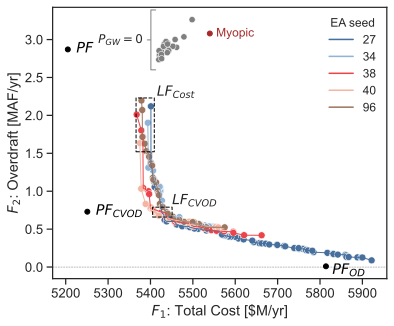

In [197]:
sns.set(rc={'figure.figsize':(6,5)})
sns.set(font_scale=1.2,style='ticks')

# pf and 
plt.plot(pf_f1f2[0],pf_f1f2[1],'o',c='black',markersize=5)
plt.text(pf_f1f2[0]+20,pf_f1f2[1]-0.04,'$PF$',fontsize='medium',color='black')

# pf gw
plt.plot(pf_od_f1f2[0],pf_od_f1f2[1],'o',c='black',markersize=5)
plt.text(pf_od_f1f2[0]+15,pf_od_f1f2[1]-0.1,'$PF_{OD}$',fontsize='medium',color='black')

# pf gw CV
plt.plot(pf_od_cv_f1f2[0],pf_od_cv_f1f2[1],'o',c='black',markersize=5)
plt.text(pf_od_cv_f1f2[0]+20,pf_od_cv_f1f2[1]-0.04,'$PF_{CVOD}$',fontsize='medium',color='black')

# myopic
plt.plot(myopic_f1f2[0],myopic_f1f2[1],'o',c='brown',markersize=5)
plt.text(myopic_f1f2[0]+15,myopic_f1f2[1]-0.04,'Myopic',fontsize='small',color='brown')


# dominated
dominated = eahist.groupby(['id'],as_index=False).aggregate({'f1':'mean', 'f2':'mean'})
dominated['seed'] = dominated.id.str.split('-').str[2].astype(int)
dominated = dominated.loc[dominated.seed==38]

# fronts
palette = ['#466f9d','#91b3d7','#eb444a','#f4b5a2','#9d7660']
nondominated = front.copy()
nondominated['seed'] = nondominated.id.str.split('-').str[2]
nondominated = nondominated.loc[nondominated.seed!=str(4)].sort_values('seed')
sns.lineplot(data=nondominated,x='f1',y='f2', hue='seed', lw=1, alpha=1, palette=palette)
sns.scatterplot(data=nondominated,x='f1',y='f2', hue='seed', s=50, alpha=1, edgecolor='white', palette=palette,legend=False)

# front no-gw-penalty
df = front_sample.loc[front_sample.type!='OD']
sns.scatterplot(data=df,x='f1-NoGW',y='f2-NoGW', s=40, alpha=1, color='grey', edgecolor='white')

# LF Zone Selections
xbuff=2
ybuff=0.06

ecolor='black'
fcolor='none'
a=1

rect1 = patches.Rectangle((cost_cost_lb-xbuff/2,cost_od_lb-ybuff/2),
                         cost_cost_ub-cost_cost_lb+xbuff-2,
                         cost_od_ub-cost_od_lb+ybuff,linewidth=1.5,linestyle='dashed',
                         edgecolor=ecolor,lw=1,facecolor=fcolor,alpha=a,zorder=10)

rect2 = patches.Rectangle((cvod_cost_lb-xbuff/2,cvod_od_lb-ybuff/2),
                          cvod_cost_ub-cvod_cost_lb+xbuff,
                         cvod_od_ub-cvod_od_lb+ybuff,linewidth=1.5,linestyle='dashed',
                         edgecolor=ecolor,lw=1,facecolor=fcolor,alpha=a,zorder=10)

# Add the patch to the Axes
plt.gca().add_patch(rect1)
plt.gca().add_patch(rect2)
# plt.gca().add_patch(rect3)

plt.annotate('$LF_{Cost}$',fontsize=14,fontweight='ultralight',
            xy=(cost_cost_ub+5, cost_od_ub+0.06))
plt.annotate('$LF_{CVOD}$',fontsize=14,fontweight='ultralight',
            xy=(cvod_cost_ub+1, cvod_od_ub+0.07))

plt.rcParams['legend.title_fontsize'] = 'small'
plt.legend(fontsize='small',title='EA seed')
plt.xlabel('$F_1$: Total Cost [\$M/yr]')
plt.ylabel('$F_2$: Overdraft [MAF/yr]');
plt.axhline(0,color='grey',linestyle='dashed',zorder=-1,lw=0.5);
plt.annotate('$P_{GW}=0$', xy=(0.3, 0.88), xytext=(0.27, 0.88), xycoords='axes fraction', 
            fontsize=12, ha='right', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=0.4', color='grey', lw=1))
# 
plt.savefig(os.path.join(fig_dir,'COSVF-front_no_annot.pdf'),dpi=300,bbox_inches="tight");

In [145]:
def add_arrow(line, position=None, direction='right', size=12, color='green'):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[0], ydata[0]),
        xy=(xdata[1], ydata[1]),
        arrowprops=dict(arrowstyle="fancy", color=color, alpha=0.5),
        size=size
    )

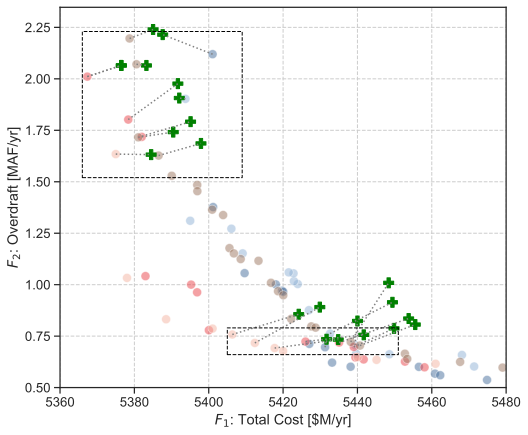

In [217]:
sns.set(rc={'figure.figsize':(8,7)})
sns.set(font_scale=1.2,style='ticks')
# fronts
palette = ['#466f9d','#91b3d7','#eb444a','#f4b5a2','#9d7660']
nondominated = front.copy()
nondominated['seed'] = nondominated.id.str.split('-').str[2]
nondominated = nondominated.loc[nondominated.seed!=str(4)].sort_values('seed')
# sns.lineplot(data=nondominated,x='f1',y='f2', hue='seed', lw=1, alpha=1, palette=palette)
sns.scatterplot(data=nondominated,x='f1',y='f2', hue='seed', s=80, alpha=0.5, edgecolor='white', palette=palette,legend=False)

# cs-ii fixed no-gw
data = front_sample.iloc[0:22]
plt.plot(data['f1-CSII'],data['f2-CSII'],'P',c='green',markersize=10,label='CS-II Fixed Carryover Storage')

# LF Zone Selections
xbuff=2
ybuff=0.06

ecolor='black'
fcolor='none'
a=1

rect1 = patches.Rectangle((cost_cost_lb-xbuff/2,cost_od_lb-ybuff/2),
                         cost_cost_ub-cost_cost_lb+xbuff-2,
                         cost_od_ub-cost_od_lb+ybuff,linewidth=2,linestyle='dashed',
                         edgecolor=ecolor,lw=1,facecolor=fcolor,alpha=a,zorder=10)

rect2 = patches.Rectangle((cvod_cost_lb-xbuff/2,cvod_od_lb-ybuff/2),
                          cvod_cost_ub-cvod_cost_lb+xbuff,
                         cvod_od_ub-cvod_od_lb+ybuff,linewidth=2,linestyle='dashed',
                         edgecolor=ecolor,lw=1,facecolor=fcolor,alpha=a,zorder=10)

# Add the patch to the Axes
plt.gca().add_patch(rect1)
plt.gca().add_patch(rect2)
# plt.gca().add_patch(rect3)

# plt.annotate('$LF_{Cost}$',fontsize=12,fontweight='bold',
#             xy=(cost_cost_lb, cost_od_ub+0.07))
# plt.annotate('$LF_{CVOD}$',fontsize=12,fontweight='bold',
#             xy=(cvod_cost_lb, cvod_od_ub+0.08))

for idx,row in data.iterrows():
    dx = row['f1-CSII']-row['f1']
    dy = row['f2-CSII']-row['f2']
    x = [row['f1'],row['f1-CSII']]
    y = [row['f2'],row['f2-CSII']]
    
    
    line = plt.plot(x, y, color='grey', linestyle='dotted',)[0]
#     add_arrow(line)
#     plt.line(x,y,dx,dy,shape='full', fc='k',lw=0, length_includes_head=True, head_width=.03)

plt.ylim(bottom=0.5)
plt.xlim(left=5360,right=5480)

plt.grid(linestyle='dashed')


plt.rcParams['legend.title_fontsize'] = 'small'
# plt.legend(title='',loc='lower left')
plt.xlabel('$F_1$: Total Cost [\$M/yr]')
plt.ylabel('$F_2$: Overdraft [MAF/yr]');

plt.savefig(os.path.join(fig_dir,'COSVF-front_cs-ii-detail.svg'),dpi=300,bbox_inches="tight");

## Plot Surface Reservoir Positions

In [62]:
# sr_ns_list

In [63]:
from itertools import chain
sr_ns_list_group_1 = list(chain(sr_ns_list[0:2], 
                                [sr_ns_list[3]],
                                sr_ns_list[6:8],
                                [sr_ns_list[14]],
                                [sr_ns_list[18]], 
                                [sr_ns_list[19]],
                                [sr_ns_list[20]],
                                sr_ns_list[22:25],
                               ))

sr_ns_list_group_2 = list(chain(sr_ns_list[2:3],
                                sr_ns_list[4:6], 
                                sr_ns_list[8:14], 
                                sr_ns_list[15:18],
                               ))

In [272]:
# sr_ns_list_group_2

In [273]:
# df_front.loc[df_front.r=='SR_BER']

In [65]:
sr_zone_positions_all.head()

,id,r,pmax,pmin,f1,f2,lb,ub,a,b,...,E[S]/Kcs,type,Unnamed: 0,sr,inflow_u,inflow_sd,i_nodes,sr_k,sr_k_u,sr_k_sd
0,102-50-38,SR_BER,142.364449,30.090971,5367.341858,2.0108,10.3,1602.3,0.035035,-142.364449,...,0.638811,Cost,0,SR_BER,379.573171,278.727223,INFLOW,1592.0,4.194185,5.711677
1,102-50-38,SR_BER,142.364449,30.090971,5367.341858,2.0108,10.3,1602.3,0.035035,-142.364449,...,0.638811,Cost,0,SR_BER,379.573171,278.727223,INFLOW,1592.0,4.194185,5.711677
2,102-50-38,SR_BUC,423.808199,17.888035,5367.341858,2.0108,10.0,135.0,1.503408,-423.808199,...,0.848262,Cost,0,SR_BUC,69.894866,68.301037,INFLOW,125.0,1.788400,1.830133
3,102-50-38,SR_BUC,423.808199,17.888035,5367.341858,2.0108,10.0,135.0,1.503408,-423.808199,...,0.848262,Cost,0,SR_BUC,69.894866,68.301037,INFLOW,125.0,1.788400,1.830133
4,102-50-38,SR_BUL,364.744097,32.810299,5367.341858,2.0108,251.0,705.0,0.235414,-364.744097,...,0.865314,Cost,0,SR_BUL,1237.362939,628.837908,INFLOW,454.0,0.366909,0.721967


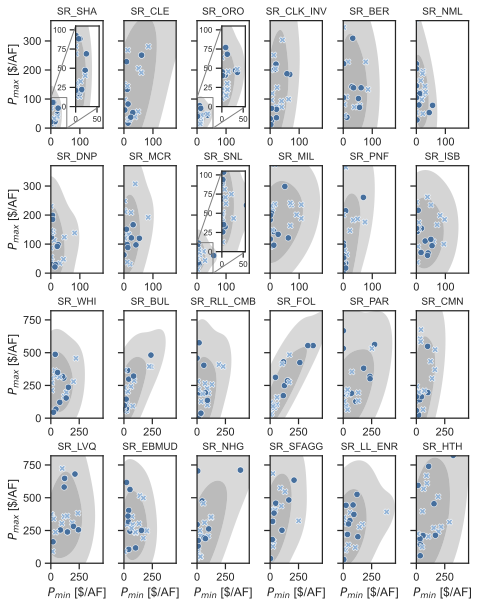

In [86]:
sns.set(rc={'figure.figsize':(7.5,10)},font_scale=1)
sns.set_style("ticks")

ncols=6
nrows=4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
plt.subplots_adjust(hspace=0.35,wspace=0.4)

palette = ['#466f9d','#91b3d7']
           
for idx,ax in enumerate(axes.flatten()):
    if idx <12:
        r = sr_ns_list_group_1[idx]
        for idx_df,df in enumerate([sr_zone_positions_all]):
            df_front = df.copy()
            data=df_front.loc[(df_front.r==r)]
            if r == 'SR_BER':
                data = data.loc[data.pmax<950]
            x = data.pmin
            y = data.pmax
            ax.set_ylim(0,370)
            ax.set_xlim(0,180)
            color =  'grey'
            kde_alpha =0.5
            fill = True
            sns.kdeplot(x=x, y=y, clip=((0,1000),(0,2000)), color=color, 
                        alpha=kde_alpha, fill=fill,  ax=ax,
                        levels=[0.05,0.35,1], bw_adjust=2)
            sns.scatterplot(data=data,x='pmin',y='pmax',style='type', hue='type', palette=palette, s=40, alpha=1,ax=ax,legend=False)
            ax.set_title(r,fontsize='small')
#             ax.set_aspect(1)
            ax.set_xlabel('')
#             ax.grid(True, which="both", ls="-",alpha=0.5)
            if r in ['SR_SHA','SR_ORO','SR_SNL']:
                ax2 = plt.axes([0,0,1,1],label=idx)
                ip = InsetPosition(ax, [0.475,0.2,0.45,0.75])
                ax2.set_axes_locator(ip)
                mark_inset(ax, ax2, loc1=2, loc2=4, fc="none", ec='0.5')
    #             CSin = ax2.contour(xbins, ybins, 1-h/(len(x)), linewidths=2)
                sns.kdeplot(x=x, y=y, clip=((0,1000),(0,2000)), color=color, alpha=kde_alpha, fill=fill,  ax=ax2,
                       levels=[0.05,0.35,1], bw_adjust=2)
                sns.scatterplot(data=data,x='pmin',y='pmax',style='type', hue='type', palette=palette, s=40, alpha=1,ax=ax2,legend=False)
                ax2.set_ylim(0,105)
                ax2.set_xlim(0,55)
                ax2.set_xlabel('')
                ax2.set_ylabel('')
                ax2.tick_params(axis='both', which='major', labelsize=8)
#                 ax2.set_aspect(1)
            if idx in (np.arange(0,(ncols*nrows)+1,ncols)): 
                ax.set_ylabel('$P_{max}$ [\$/AF]')
            else:
                ax.set_ylabel('')
                ax.set_yticklabels('')
    elif idx >=12 and idx<26:
        r = sr_ns_list_group_2[idx-12]
        for idx_df,df in enumerate([sr_zone_positions_all]):
            df_front = df.copy()
            data=df_front.loc[(df_front.r==r)]
            x = data.pmin
            y = data.pmax
            ax.set_ylim(0,820)
            ax.set_xlim(0,460)
            fill = True
            sns.kdeplot(x=x, y=y, clip=((0,1000),(0,2000)), color=color, 
                        alpha=kde_alpha, fill=fill,  ax=ax,
                        levels=[0.05,0.35,1], bw_adjust=2)
            sns.scatterplot(data=data,x='pmin',y='pmax',style='type', hue='type', palette=palette, s=40, alpha=1,ax=ax,legend=False)
            ax.set_title(r,fontsize='small')
#             ax.set_aspect(1)
            ax.set_xlabel('')
            if idx>17: ax.set_xlabel('$P_{min}$ [\$/AF]')
#             ax.set_xticklabels('')
            if idx in (np.arange(0,(ncols*nrows)+1,ncols)): 
                ax.set_ylabel('$P_{max}$ [\$/AF]')
            else:
                ax.set_ylabel('')
                ax.set_yticklabels('')
    else: 
        ax.axis('off')

plt.savefig(os.path.join(fig_dir,'COSVF-SR.svg'),dpi=600, bbox_inches="tight");


In [ ]:
sns.set(rc={'figure.figsize':(11,10)},font_scale=1)
sns.set_style("ticks")
ncols=6
nrows=4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
plt.subplots_adjust(hspace=0.5,wspace=0.25)
df = sr_zone_positions.loc[sr_zone_positions.type!='OD'].copy()
df['E[p(s)]'] = df['E[p(s)]']/1e3
for idx,ax in enumerate(axes.flatten()):
    if idx <12:
        r = sr_ns_list_group_1[idx]
        if r == 'SR_BER':
            df = df.loc[df.pmax<950]
        sns.scatterplot(data=df.loc[df.r==r],x="pavg",y='E[S]/Kcs',ax=ax,style='type',hue='type',s=90,
                       palette=['darkblue','lightblue'])
        
        ax.legend('')
        ax.set_title(r)
        ax.set_ylim(-0.075,1.075)
        ax.set_xlim(left=-5)
        
        if idx < 20: 
            ax.set_xlabel('')
#             ax.set_xticklabels('')
        else:
            ax.set_xlabel("$P_{avg}$ [\$/AF]")
            
        if idx in (np.arange(0,(ncols*nrows)+1,ncols)): 
            ax.set_ylabel('E[S] / $K_{CS}$ [%]')
#             ax.set_ylabel('RP')
        else:
            ax.set_ylabel('')
            ax.set_yticklabels('')
    elif idx >=12 and idx<26:
        r = sr_ns_list_group_2[idx-12]    
        sns.scatterplot(data=df.loc[df.r==r],x="pavg",y='E[S]/Kcs',ax=ax,style='type',hue='type',s=90,
                       palette=['darkblue','lightblue'])
        
        ax.legend('')
        ax.set_title(r)
        ax.set_ylim(-0.075,1.075)
        ax.set_xlim(left=-5)
        
        if idx < 18: 
            ax.set_xlabel('')
#             ax.set_xticklabels('')
        else:
            ax.set_xlabel("$P_{avg}$ [\$/AF]")
            
        if idx in (np.arange(0,(ncols*nrows)+1,ncols)): 
            ax.set_ylabel('E[S] / $K_{CS}$ [%]')
#             ax.set_ylabel('RP')
        else:
            ax.set_ylabel('')
            ax.set_yticklabels('')
    else:
        axes[2][-2].legend(bbox_to_anchor=(0.85,0.55))
        ax.axis('off')

# plt.savefig(os.path.join(fig_dir,'Pavg - E[S].svg'.format(r)),dpi=300, bbox_inches="tight");

# Correlation Analysis

In [ ]:
def cluster_corr(corr_array, corr_p_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='ward',optimal_ordering=True)
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
        corr_p_array = corr_p_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :], corr_p_array.iloc[idx, :].T.iloc[idx, :]
    
    return corr_array[idx, :][:, idx], corr_p_array[idx, :][:, idx]

# Compute the correlation matrix
def corr_r_front(df,var1,var2):
    df_corr = pd.DataFrame() # Correlation matrix
    for r in df.r.unique():
        corr = stats.spearmann(df.loc[df.r==r][var1], df.loc[df.r==r][var2])
        df_corr.loc[r,'r'] = round(corr[0],3)
        df_corr.loc[r,'p'] = round(corr[1],5)
    return df_corr

In [ ]:
###### s_idx, e_idx = zone1_idx, len(sr_pmax)
s_idx, e_idx = 0, len(sr_zone_positions) #zone1_idx
pmarg = corr_r_front(sr_zone_positions.iloc[s_idx:e_idx],'Pmarg(E[S])','f1').sort_values('r')
ap = corr_r_front(sr_zone_positions.iloc[s_idx:e_idx],'RP','f1')
pmarg.join(ap,lsuffix='_pmarg',rsuffix='_ap')

In [ ]:
def sort_ns(df,sort_list):
    # Define the sorter

    # Create the dictionary that defines the order for sorting
    sorterIndex = dict(zip(sort_list, range(len(sort_list))))

    # Generate a rank column that will be used to sort
    # the dataframe numerically
    df['order'] = df['r'].map(sorterIndex)

    df.sort_values(['order'], inplace = True)
    df.drop('order', 1, inplace = True)
    
    return df.copy()

In [ ]:
sns.set(rc={'figure.figsize':(20,20)},font_scale=1.2)
sns.set_style("ticks")

var = 'pavg'
# var = 'value'

# s_idx, e_idx = zone1_idx, len(sr_pmax)
# s_idx, e_idx = 0, len(sr_pmax)
# df = sr_klb_cost.iloc[s_idx:e_idx].copy()
# df = sort_ns(sr_zone_positions_knee,sr_ns_list)
df = sr_zone_positions.loc[sr_zone_positions.type!='OD']
df = df.pivot_table(columns='r',values=var,index='id').reindex(columns=sr_ns_list)

# Compute the correlation matrix
df_corr = pd.DataFrame() # Correlation matrix
df_p = pd.DataFrame()  # Matrix of p-values
for x in df.columns:
    for y in df.columns:
        corr = stats.spearmanr(df[x], df[y])
        df_corr.loc[x,y] = corr[0]
        df_p.loc[x,y] = corr[1]

# df_corr, df_p = cluster_corr(df_corr, df_p)
# 
# # Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df_corr, mask=mask, cmap=cmap, vmax=0.6, vmin=-0.6, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .5}, cbar=True)


df_corr = df_corr[df_p<0.05]
mask = np.triu(np.ones_like(df_corr, dtype=bool))

sns.heatmap(df_corr, mask=mask, alpha=0,
            square=True, linewidths=2, 
            annot = True, fmt='.1g', annot_kws=dict(fontsize='x-small',color='k'),cbar=False)

# plt.savefig(os.path.join(fig_dir,'{}-Corr_SR_knee_pearson.png'.format(var)),dpi=600, bbox_inches="tight");

In [ ]:
sns.set(rc={'figure.figsize':(5,5)},font_scale=1.4,style='ticks')

# fig, axes = plt.subplots(nrows=1, ncols=1)

# df = sr_zone_positions_front.copy()
# df['pavg'] = df.groupby('r')['pavg'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
# df = df.pivot_table(columns='r',values=var,index=['id','zone']).reindex(columns=sr_ns_list)
# df = df.reset_index()

# df2 = sr_zone_positions_knee.copy()
# df2['pavg'] = df2.groupby('r')['pavg'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
# df2 = df2.pivot_table(columns='r',values=var,index=['id','zone']).reindex(columns=sr_ns_list)
# df2 = df2.reset_index()

df3 = sr_zone_positions_all.copy()
df3['pavg'] = df3.groupby('r')['pavg'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
df3 = df3.pivot_table(columns='r',values=var,index=['id']).reindex(columns=sr_ns_list)
df3 = df3.reset_index()


var = 'pavg'
r1 = 'SR_ORO'
r2 = 'SR_WHI'

p = sns.jointplot(data=df3,x=r1,y=r2,palette=['orange','blue'],joint_kws=(dict(alpha=0)))

# sns.regplot(data=df,x=r1,y=r2,scatter_kws=(dict(alpha=1,s=10)),color='blue',ax=p.ax_joint)
# sns.regplot(data=df2,x=r1,y=r2,scatter_kws=(dict(alpha=1,s=10)),color='orange',ax=p.ax_joint)
sns.regplot(data=df3,x=r1,y=r2,scatter_kws=(dict(alpha=1,s=10)),color='blue',ax=p.ax_joint)

p.ax_joint.legend('')
p.ax_joint.set_ylim(-.1,1.1)
p.ax_joint.set_xlim(-.1,1.1)
plt.ylabel(r2)
plt.xlabel(r1)
# plt.ylim(bottom=0)
# plt.xlim(left=0)
# plt.savefig(os.path.join(fig_dir,'Pmarg-Corr_{}_{}_detail.png'.format(r1,r2)),dpi=600, bbox_inches="tight");
# plt.xlim()

### COSV Curves

In [ ]:
sns.set(rc={'figure.figsize':(5,5)},font_scale=1.4,style='ticks')
df = sr_zone_positions

r = 'SR_SHA'

sns.scatterplot(df.loc[df.r==r]['pmin'],df.loc[df.r==r]['pmax'],hue=df.loc[df.r==r]['type'])
plt.title(r)
plt.xlabel('$P_{min}$ [\$/af]')
plt.ylabel('$P_{max}$ [\$/af]')
plt.ylim(bottom=-2)

plt.savefig(os.path.join(fig_dir,'{}-Pmax-Pmin.png'.format(r)),dpi=600, bbox_inches="tight");

In [ ]:
sns.set(rc={'figure.figsize':(4,4)},font_scale=1.4,style='ticks')

r = 'SR_SHA'
q = 0.98
pmax_u, pmax_l = 125, 80
pmin_u, pmin_l = 20, 0

# pmax_u, pmax_l = 10, 5
# pmin_u, pmin_l = 10, 5

# pmax_u, pmax_l = 75, 50
# pmin_u, pmin_l = 40, 31

# r = 'SR_ORO'
# q=0.97
# pmax_u, pmax_l = 350, 300
# pmin_u, pmin_l = 20, 0

# pmax_u, pmax_l = 100, 50
# pmin_u, pmin_l = 100, 70

# pmax_u, pmax_l = 35, 0
# pmin_u, pmin_l = 40, 0

# r = 'SR_FOL'
# q=0.85
# pmax_u, pmax_l = 650, 600
# pmin_u, pmin_l = 350, 300

# pmax_u, pmax_l = 1300, 1200
# pmin_u, pmin_l = 20, 0

# pmax_u, pmax_l = 220, 0
# pmin_u, pmin_l = 20, 0


sr_stat = sr_zone_positions_all.loc[
    (sr_zone_positions_all.r==r) & 
    (sr_zone_positions_all.pmax>pmax_l) & (sr_zone_positions_all.pmax<pmax_u) &
    (sr_zone_positions_all.pmin>pmin_l) & (sr_zone_positions_all.pmin<pmin_u)].iloc[0]

s_storage = sep_storage_sr.loc[(sep_storage_sr.r==r) & (sep_storage_sr.id==sr_stat.id)]

x,y,a,b,c = calvin.cosvf_fit_from_params(sr_stat['pmin']*-1, sr_stat['pmax']*-1, 
                             sr_stat['lb'], sr_stat['ub'],k_count=100)
plt.plot(x,y/1000)

plt.scatter(sr_stat.value-sr_stat.RP,sr_stat['E[p(s)]']/1000,label='E[p(s)]',c='blue')
plt.scatter(sr_stat.value,sr_stat['P(E[S])']/1000,label='P(E[s])',c='orange')

plt.ylabel('P [$M]')
plt.xlabel('CO Storage [TAF]')

plt.ylim(0,sr_zone_positions_all.loc[
    (sr_zone_positions_all.r==r)]['c'].quantile(q)/1000)
# plt.legend(loc='upper right')

ax = plt.twinx()
ax.hist(s_storage.value,color='grey',alpha=1,histtype='step')

plt.annotate("""$P_{max}$: %d \$/af\n$P_{min}$: %d \$/af\n$RP$: %d TAF""" % (int(round(sr_stat.pmax,0)), float(round(sr_stat.pmin,1)), float(round(sr_stat.RP,1))),
             (0.55,0.76),
             xycoords='figure fraction',fontsize='small')

plt.ylabel('Frequency [years]')

# plt.savefig(os.path.join(fig_dir,'{}-COSVF_curve-{}-{}.png'.format(r,int(sr_stat.pmax),int(sr_stat.pmin))),dpi=600, bbox_inches="tight");

In [ ]:
int(round(sr_stat.pmax,0))

In [ ]:
sns.set(rc={'figure.figsize':(4,4)},font_scale=1.4,style='ticks')

# id = '102-65-25'
# id = '111-19-82'
# id = '121-85-27'
# id = '93-61-25'
# id = '109-94-25'
# id = '121-55-27'
# id = '121-85-27'
# id = '105-83-27'
# id= '123-48-82'
# id = '93-61-25'
id= '93-53-27'
# id='103-17-25'
# id = '114-83-82'
sr = 'SR_GNT'

s_storage = sep_storage_sr.loc[(sep_storage_sr.r==sr) & (sep_storage_sr.id==id)]
sr_stat = sr_zone_positions.loc[(sr_zone_positions.r==sr) & (sr_zone_positions.id==id)]

x,y,a,b,c = calvin.cosvf_fit_from_params(float(sr_stat['pmin']*-1), float(sr_stat['pmax']*-1), 
                             float(sr_stat['lb']), float(sr_stat['ub']),k_count=100)
plt.plot(x,y/1000)

plt.scatter(sr_stat.value,sr_stat['E[p(s)]']/1000,label='E[p(s)]',c='blue')
plt.scatter(sr_stat.value,sr_stat['P(E[S])']/1000,label='P(E[s])',c='orange')

plt.ylabel('P [$M]')

plt.legend(loc='upper center')

ax = plt.twinx()
ax.hist(s_storage.value,color='grey',alpha=0.2,cumulative=True,density=True,histtype='step')

plt.annotate('Pmax:{}\nRP:{}'.format(int(sr_stat.pmax*-1),float(round(sr_stat.RP,1))),(0.5,0.5),
             xycoords='figure fraction',fontsize='small')

plt.ylabel('Cumulative Frequency (S)')


### Value Boxplots

In [ ]:
sns.set(rc={'figure.figsize':(14,3)},font_scale=1)
sns.set_style("ticks")
df=front_ref_positions[(front_ref_positions['param']=='pmin')].copy()
df['value'] = df['value']*-1
sns.boxplot(data=df,x='r',y='value',color='lightgrey',fliersize=0, order=sr_ns_list)
# sns.stripplot(data=df,x='r', y='value',hue='f1', palette='spring',size=4,alpha=0.75,edgecolor=None,order=sr_ns_list)
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('$P_{min}$ [\$/AF]')
plt.legend('')
# plt.ylim(-650,20)
# plt.savefig(os.path.join(fig_dir,'Pmin_box.png'),dpi=600, bbox_inches="tight");

In [ ]:
sns.set(rc={'figure.figsize':(14,3)},font_scale=1)
sns.set_style("ticks")
df=front_ref_positions[(front_ref_positions['param']=='pmax')].copy()
df['value'] = df['value']*-1
sns.boxplot(data=df,x='r',y='value',color='lightgrey',fliersize=0,order=sr_ns_list)
# sns.stripplot(data=df,x='r', y='value',hue='f2', palette='spring',size=5,alpha=0.75,edgecolor=None,order=sr_ns_list)
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('$P_{max}$ [\$/AF]')
plt.legend('')
plt.savefig(os.path.join(fig_dir,'Pmax_box.png'),dpi=600, bbox_inches="tight");

In [ ]:
# sr_zone_positions_all_gw = sr_zone_positions_all[['id','zone']].merge(gw_positions,on='id').drop_duplicates(['id','zone','r'])
sr_zone_positions_all_gw = sr_zone_positions[['id']].merge(gw_positions,on='id').drop_duplicates(['id','r'])

In [ ]:
sns.set(rc={'figure.figsize':(12,3)},font_scale=1)
sns.set_style("ticks")
df=sr_zone_positions_all_gw.copy()
# sns.boxplot(data=df,x='r',y='p',hue='zone',fliersize=1,linewidth=1)
sns.boxplot(data=df,x='r',y='p',fliersize=1,linewidth=1,color='grey')
# sns.stripplot(data=df,x='r', y='value',hue='f1', palette='spring',size=5,alpha=0.75,edgecolor=None)
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('$P_{GW}$ [\$/AF]')
plt.yticks([0,250,500,750,1000,1250,1500])
plt.grid(True, which="both", axis='y', ls="--",alpha=1)
# plt.legend('')
# plt.savefig(os.path.join(fig_dir,'Pgw_box.png'),dpi=600, bbox_inches="tight");

In [ ]:
sns.set(rc={'figure.figsize':(12,3)},font_scale=1)
sns.set_style("ticks")
df=sr_zone_positions.copy() #.loc[sr_zone_positions_all.r!='SR_CLE']
df['RP:Kub'] = df['RP:Kub']*100
# sns.boxplot(data=df,x='r',y='RP:Kub',hue='zone',order=sr_ns_list[0:1]+sr_ns_list[2:],fliersize=1,linewidth=1)
sns.boxplot(data=df,x='r',y='RP:Kub',order=sr_ns_list,fliersize=1,linewidth=1,color='grey')

# sns.stripplot(data=df,x='r', y='RP:Kub',hue='f2', palette='spring',size=5,alpha=0.75,edgecolor=None,order=sr_ns_list)
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('$RP$ % of $K_{cs}$')
# plt.yticks([0,250,500,750,1000,1250,1500])
plt.grid(True, which="both", axis='y', ls="--",alpha=1)
# plt.legend('')
# plt.savefig(os.path.join(fig_dir,'RP_box.png'),dpi=600, bbox_inches="tight");

In [ ]:
sns.set(rc={'figure.figsize':(12,3)},font_scale=1)
sns.set_style("ticks")
df=sr_zone_positions.loc[sr_zone_positions.r!='SR_CLE'].copy()
# df['E[p(s)]'] = df['E[p(s)]']/1e3
# sns.boxplot(data=df,x='r',y='E[p(s)]',hue='zone',order=sr_ns_list[0:1]+sr_ns_list[2:],fliersize=1,linewidth=1)
sns.boxplot(data=df,x='r',y='E[p(s)]',order=sr_ns_list[0:1]+sr_ns_list[2:],fliersize=1,linewidth=1,color='grey')
# sns.stripplot(data=df,x='r', y='Pmarg(E[S])',hue='f2', palette='spring',size=5,alpha=0.75,edgecolor=None,order=sr_ns_list)
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('$E[p(s)]$ [\$M]')
plt.legend('')
# plt.yscale('log')
plt.grid(True, which="both", axis='y', ls="--",alpha=1)
# ax.set_ylim(0.1,2000)
# plt.savefig(os.path.join(fig_dir,'E[p(s)]_box.png'),dpi=600, bbox_inches="tight");

In [ ]:
sns.set(rc={'figure.figsize':(12,3)},font_scale=1)
sns.set_style("ticks")
df=sr_zone_positions.loc[sr_zone_positions.r!='SR_CLE'].copy()
# df['E[p(s)]'] = df['E[p(s)]']/1e3
# sns.boxplot(data=df,x='r',y='E[p(s)]',hue='zone',order=sr_ns_list[0:1]+sr_ns_list[2:],fliersize=1,linewidth=1)
sns.boxplot(data=df,x='r',y='Pmarg(E[S])',order=sr_ns_list[0:1]+sr_ns_list[2:],fliersize=1,linewidth=1,color='grey')
# sns.stripplot(data=df,x='r', y='Pmarg(E[S])',hue='f2', palette='spring',size=5,alpha=0.75,edgecolor=None,order=sr_ns_list)
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('$P\'(E[S])$ [\$/AF]')
plt.legend('')
# plt.yscale('log')
plt.grid(True, which="both", axis='y', ls="--",alpha=1)
# ax.set_ylim(0.1,2000)
# plt.savefig(os.path.join(fig_dir,'E[p(s)]_box.png'),dpi=600, bbox_inches="tight");

In [ ]:
sns.set(rc={'figure.figsize':(0.5,3)},font_scale=1)
sns.set_style("ticks")
df=sr_zone_positions.loc[sr_zone_positions.r=='SR_CLE'].copy()
# df['E[p(s)]'] = df['E[p(s)]']/1e3
sns.boxplot(data=df,x='r',y='E[p(s)]',hue='type',fliersize=1,linewidth=1)
# sns.stripplot(data=df,x='r', y='Pmarg(E[S])',hue='f2', palette='spring',size=5,alpha=0.75,edgecolor=None,order=sr_ns_list)
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('$E[p(s)]$ [\$M]')
plt.legend('')
# plt.yscale('log')
plt.grid(True, which="both", axis='y', ls="--",alpha=1)
# ax.set_ylim(0.1,2000)
# plt.savefig(os.path.join(fig_dir,'E[p(s)]_box_SR_CLE.png'),dpi=600, bbox_inches="tight");

In [ ]:
sns.set(rc={'figure.figsize':(2,6)},font_scale=1,style='ticks')
nrows=4
ncols=1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
r='SR_WHI'

df = sr_zone_positions.loc[sr_zone_positions.r==r]

ms=10

window = 45


sns.regplot(x=df['f1'], y=df['pmax'],ax=axes[0],
            line_kws=dict(color='black'),
                    scatter_kws=dict(s=2));
axes[0].set_ylim(top=df['pmax'].quantile(0.95))
axes[0].set_xticklabels('')
axes[0].set_ylabel('$P_{max}$ [\$/AF]')

sns.regplot(x=df['f1'], y=df['pmin'],ax=axes[1],
            line_kws=dict(color='black'),
            scatter_kws=dict(s=2));
axes[1].set_ylim(top=df['pmin'].quantile(0.95))
axes[1].set_xticklabels('')
axes[1].set_ylabel('$P_{min}$ [\$/AF]')

sns.regplot(x=df['f1'], y=df['RP'],ax=axes[2],
            line_kws=dict(color='black'),
            scatter_kws=dict(s=2));
axes[2].set_ylim(top=df['RP'].quantile(0.95))
axes[2].set_xticklabels('')
axes[2].set_ylabel('$RP$ [TAF]')


sns.regplot(x=df['f1'], y=df['Pmarg(E[S])'],ax=axes[3],
            line_kws=dict(color='black'),
            scatter_kws=dict(s=2));
axes[3].set_ylim(top=df['Pmarg(E[S])'].quantile(0.95));
axes[3].set_ylabel('$P_{marg}(E[S])$ [\$/af]')

axes[3].set_xlabel('F1: Total Costs ($M/yr)');

# plt.savefig(os.path.join(fig_dir,'{}-P and RP with F1.png'.format(r)),dpi=600, bbox_inches="tight");

In [ ]:
df.columns

In [ ]:
sr_zone_positions['value_kcs'] = (sr_zone_positions['value']-sr_zone_positions['lb'])/(sr_zone_positions['ub']-sr_zone_positions['lb'])

In [ ]:
sr_zone_positions.columns

In [ ]:
sns.set(rc={'figure.figsize':(10,11)},font_scale=1)
sns.set_style("ticks")
ncols=5
nrows=5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
plt.subplots_adjust(hspace=0.45,wspace=0.2)
df = sr_zone_positions #.loc[sr_zone_positions.type.isin(['Cost','CVOD'])].copy()
df['E[p(s)]'] = df['E[p(s)]']/1e3
for idx,ax in enumerate(axes.flatten()):
    if idx <26:
        r = sr_ns_list[idx]
        df1 = df.loc[df.r==r]
        sns.scatterplot(data=df1,x="pavg",y='value_kcs',ax=ax,hue=df1['RP:Kub']*100,
                        palette='copper_r',legend=False,s=80,alpha=1)
#         sns.boxplot(data=df1,y='value_kcs',hue='type',ax=ax,orient='h',width=0.2)
#         ax.axvline(df1.loc[df1.type=='Cost']['pavg'].mean(),c='blue')
#         ax.axvline(df1.loc[df1.type=='CVOD']['pavg'].mean(),c='orange')
#         ax.axvline(df1.loc[df1.type=='OD']['pavg'].mean(),c='red')
        ax.set_title(r)
        ax.set_ylim(-0.1,1.1)
        
#         ax.set_yticklabels(labels=['','0','1/2','Full'])
        ax.set_xlim(left=-10)
#         ax.legend(fontsize='xx-small')
        
        if idx < 20: 
            ax.set_xlabel('')
#             ax.set_xticklabels('')
        else:
            ax.set_xlabel("$P\'E[S]$ [\$/AF]")
#             ax.set_xlabel("$P_{avg}$ [\$/AF]")
            
        if idx in (np.arange(0,(ncols*nrows)+1,ncols)): 
            ax.set_ylabel('E[S] / K')
#             ax.set_ylabel('RP')
        else:
            ax.set_ylabel('')
            ax.set_yticklabels('')
            
    else:
        axes[2][-2].legend(bbox_to_anchor=(0.85,0.55))
        ax.axis('off')

# plt.savefig(os.path.join(fig_dir,'Pmarg - E[S] - RP.pdf'.format(r)),dpi=300, bbox_inches="tight");

In [ ]:
sns.set(rc={'figure.figsize':(14,11)},font_scale=1.1)
sns.set_style("ticks")
ncols=5
nrows=5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
plt.subplots_adjust(hspace=0.25,wspace=0.15)

df2 = sr_zone_positions_all.copy()
df2['pmin'] = df2.groupby('r')['pmin'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
df2['pmax'] = df2.groupby('r')['pmax'].transform(lambda x: (x-x.min())/(x.max()-x.min()))

df = sr_zone_positions_all.copy()
df['pmin'] = df.groupby('r')['pmin'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
df['pmax'] = df.groupby('r')['pmax'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
df['Pmarg(E[S])'] = df.groupby('r')['Pmarg(E[S])'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
df['RP'] = df.groupby('r')['RP'].transform(lambda x: (x-x.min())/(x.max()-x.min()))

# E[p(s)]
for idx,ax in enumerate(axes.flatten()):
    if idx <26:
        r = sr_ns_list[idx]
        
        # E[p(s)] Pmarg(E[S])
        ax.tricontourf(df.loc[df.r==r]['pmin'],df.loc[df.r==r]['pmax'],df.loc[df.r==r]['Pmarg(E[S])'],antialiased=True)
        sns.kdeplot(df.loc[df.r==r]['pmin'],df.loc[df.r==r]['pmax'],color='blue',
                    levels=[0.35],ax=ax,alpha=1,bw_adjust=1.5,clip=((0,2000),(0,2000)))
        sns.kdeplot(df2.loc[df2.r==r]['pmin'],df2.loc[df2.r==r]['pmax'],color='orange',
                    levels=[0.35],ax=ax,alpha=1,bw_adjust=1.5,clip=((0,2000),(0,2000)))
        
        ax2 = plt.axes([0,0,1,1],label=idx)
        ip = InsetPosition(ax, [0.525,0.3,0.45,0.65])
        ax2.set_axes_locator(ip)
        ax2.tricontourf(df.loc[df.r==r]['pmin'],df.loc[df.r==r]['pmax'],df.loc[df.r==r]['RP'],antialiased=True)
        sns.kdeplot(df.loc[df.r==r]['pmin'],df.loc[df.r==r]['pmax'],color='blue',
                    levels=[0.35],ax=ax2,alpha=1,bw_adjust=1.5,clip=((0,2000),(0,2000)))
        sns.kdeplot(df2.loc[df2.r==r]['pmin'],df2.loc[df2.r==r]['pmax'],color='orange',
                    levels=[0.35],ax=ax2,alpha=1,bw_adjust=1.5,clip=((0,2000),(0,2000)))
        
#         sns.scatterplot(data=df.loc[df.r==r],x=df.loc[df.r==r]['pmin'],y='pmax',ax=ax2,alpha=0.65,s=5,facecolors='none', edgecolors='white')
#         sns.scatterplot(data=df.loc[df.r==r],x=df.loc[df.r==r]['pmin'],y='pmax',ax=ax,alpha=0.65,s=5,facecolors='none', edgecolors='white')
        
        if idx==0:
            ax.annotate('P\'(E[S])',(1,0),fontsize='small')
            ax2.annotate('RP',(0.55,0.85),fontsize='small')
        
        ax.legend('')
        ax.set_title(r)
        
        ax2.set_xlabel('')
        ax2.set_ylabel('')
        
        ax.set_yticks([0,1])
        ax.set_xticks([0,1])
        
        ax.set_ylim(bottom=-0.1,top=1.1)#df.loc[df.r==r]['Pmarg(E[S])'].min())
        ax2.set_ylim(bottom=-0.1,top=1.1)
        ax2.set_xlim(left=-0.1,right=1.1)
        ax.set_xlim(left=-0.1,right=1.5)
        
        ax2.set_xticklabels('')
        ax2.set_yticklabels('')
        
        if idx < 20: 
            ax.set_xlabel('')
            ax.set_xticklabels('')
        else:
            ax.set_xlabel('$P_{min}$')
            
        if idx in (np.arange(0,(ncols*nrows)+1,ncols)): 
            ax.set_ylabel('$P_{max}$')
        else:
            ax.set_ylabel('')
            ax.set_yticklabels('')
            
    else:
        axes[2][-2].legend(bbox_to_anchor=(0.85,0.55))
        ax.axis('off')
# 
# plt.savefig(os.path.join(fig_dir,'E[p(s)] - Pmin - Pmax - RP - Response.png'.format(r)),dpi=600, bbox_inches="tight");

In [ ]:
sns.set(rc={'figure.figsize':(11,11)},font_scale=1.1)
sns.set_style("ticks")
ncols=5
nrows=5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
plt.subplots_adjust(hspace=0.25,wspace=0.15)

# df2 = sr_zone_positions_knee.copy()
# df2['pmin'] = df2.groupby('r')['pmin'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
# df2['pmax'] = df2.groupby('r')['pmax'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
# df2['Pmarg(E[S])'] = df2.groupby('r')['Pmarg(E[S])'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
# df2['RP'] = df2.groupby('r')['RP'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
# df2['E[p(s)]'] = df2.groupby('r')['E[p(s)]'].transform(lambda x: (x-x.min())/(x.max()-x.min()))

df = sr_zone_positions_all.copy()
df['pmin'] = df.groupby('r')['pmin'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
df['pmax'] = df.groupby('r')['pmax'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
df['Pmarg(E[S])'] = df.groupby('r')['Pmarg(E[S])'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
df['RP'] = df.groupby('r')['RP'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
df['E[p(s)]'] = df.groupby('r')['E[p(s)]'].transform(lambda x: (x-x.min())/(x.max()-x.min()))

df2 = df.loc[df.zone=='knee']
df = df.loc[df.zone=='front']
# E[p(s)] RP Pmarg(E[S])
xvar = 'pmin'
yvar = 'pmax'
response = 'RP'

for idx,ax in enumerate(axes.flatten()):
    if idx <26:
        r = sr_ns_list[idx]
        
        # E[p(s)] Pmarg(E[S])
#         ax.tricontourf(df2.loc[df2.r==r][xvar],df2.loc[df2.r==r][yvar],df2.loc[df2.r==r][response],antialiased=True)
        ax.tricontourf(df.loc[df.r==r][xvar],df.loc[df.r==r][yvar],df.loc[df.r==r][response],antialiased=True)
        sns.kdeplot(df.loc[df.r==r][xvar],df.loc[df.r==r][yvar],color='blue',
                    levels=[0.35],ax=ax,alpha=1,bw_adjust=1.5,clip=((0,2000),(0,2000)))
        sns.kdeplot(df2.loc[df2.r==r][xvar],df2.loc[df2.r==r][yvar],color='orange',
                    levels=[0.35],ax=ax,alpha=1,bw_adjust=1.5,clip=((0,2000),(0,2000)))


        ax.legend('')
        ax.set_title(r)
        
        ax.set_yticks([0,1])
        ax.set_xticks([0,1])
        
        ax.set_ylim(bottom=-0.1,top=1.1)
        ax.set_xlim(left=-0.1,right=1.1)
        
        if idx < 20: 
            ax.set_xlabel('')
            ax.set_xticklabels('')
        else:
            ax.set_xlabel('{}'.format(xvar))
            
        if idx in (np.arange(0,(ncols*nrows)+1,ncols)): 
            ax.set_ylabel('{}'.format(yvar))
        else:
            ax.set_ylabel('')
            ax.set_yticklabels('')
            
    else:
        axes[2][-2].legend(bbox_to_anchor=(0.85,0.55))
        ax.axis('off')

plt.savefig(os.path.join(fig_dir,'{} - {} - {} - Response.png'.format(xvar,yvar,response)),dpi=600, bbox_inches="tight");